### Inicialización de Entorno

#### Imports y Funciones

##### Imports

In [ ]:
#imports
import pickle
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge, Lasso,RidgeCV
from sklearn.impute import SimpleImputer
from sklearn import preprocessing
from sklearn.impute import KNNImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import MissingIndicator, IterativeImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestRegressor, StackingRegressor
from sklearn.model_selection import cross_val_score,cross_validate
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn import tree
import time
from threading import Thread
from xgboost import XGBRegressor
np.random.seed(42)
save_path="/content/drive/My Drive/Colab Notebooks/"
file_ds_post_knn=save_path+'p2_dataset_post_knn.csv' # csv salvado despues de entrenar por knn
file_ds_after_transform=save_path+'p2_dataset_transformado.csv' # csv salvado despues de transformar los datos
file_ds_almos_ready_wo_pca=save_path+'p2_datasetalmos_ready_wo_pca.csv' # csv salvado despues de transformar los datos
file_randomsearch_rf=save_path+'p2_randomsearch_rf.pkl' # pkl randomsearch para random forest
file_randomsearch_xg=save_path+'p2_randomsearch_xg.pkl' # pkl randomsearch para xgboost
file_cache_list=[file_ds_post_knn, file_ds_after_transform, file_ds_almos_ready_wo_pca,file_randomsearch_rf,file_randomsearch_xg]

##### Funciones

##### Escalado el dataset antes del split

In [ ]:
def escal_split_before(data,the_y='price', test_size=0.30, random_state=42, scaler = RobustScaler()):
  """
  Esta funcion realiza el escalado de X antes de generar X_train y X_test
  
  Parameters
  ----------
  data : pandas DataFrame
      dataframe que contiene X e y
  the_y : str o int
      columna que contiene el dato target
  """
  X = data.drop(columns=[the_y])
  cols=X.columns
  X = pd.DataFrame(scaler.fit_transform(data.drop(columns=[the_y])), columns=cols)
  y = data[the_y]
  return train_test_split(
      X, y, test_size=test_size, random_state=random_state,)

##### Escalado el dataset despues del split

In [ ]:
def escal_split_after(data,the_y='price',test_size=0.30, random_state=42, scaler = RobustScaler()):
  """
  Esta función realiza un train_test_split, luego realiza el escalado de X_train y X_test
  
  Parameters
  ----------
  data : pandas DataFrame
      dataframe que contiene X e y
  the_y : str o int
      columna que contiene el dato target
  """
  X = data.drop(columns=[the_y])
  cols=X.columns
  y = data[the_y]
  X_train, X_test, y_train, y_test = train_test_split(
      X, y, test_size=test_size, random_state=random_state)
  scaler.fit(X_train)
  X_train = pd.DataFrame(scaler.transform(X_train), columns=cols)
  X_test = pd.DataFrame(scaler.transform(X_test), columns=cols)
  return X_train, X_test, y_train, y_test


##### exp_mean_squared_error

In [ ]:
# calcula el means sq
def exp_mean_squared_error(y_true, y_pred, squared=False):
  """Calcuala mean_squared_error de la pediccion revirtiendo log1p -> np.exp(n) - 1. Retorna este valor en forma negativa al igual neg_mean_squared_error
  
  Parameters
  ----------
  y_true : np.array
      Muestras reales
  y_pred : np.array
      Muestras pedichas
  squared: bool
      Iguale que mean_squared_error
  """
  print('sq mean_squared_error:',np.sqrt(mean_squared_error(np.exp(y_true) - 1,np.exp(y_pred) -1)))
  print('y_true.shape:',y_true.shape)
  print('y_pred.shape:',y_pred.shape)
  return mean_squared_error(np.exp(y_true) - 1,np.exp(y_pred) -1, squared=squared)

##### Funciones Modeos Basicos

In [ ]:
#Inicio Listas y Variables para la evaluacion de desempeño
max_nei = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,25] #Iteraciones
# max_nei = [1,2,3,5]
# models = ['tree','knn'] #Modelos
models = ['tree'] #Modelos
list_rmse_train={}
list_rmse_test={}

# Entrenamiento y Evaluacion Knn
def myknn(scoreador=mean_squared_error):
  scaler=MinMaxScaler()
  list_rmse_train['knn']=[]
  list_rmse_test['knn']=[]
  for nei in max_nei:
      print(nei,' ',end="")
      knn_regressor = KNeighborsRegressor(n_neighbors=nei)
      y_train_l=False
      y_train_l=scaler.fit_transform(pd.DataFrame(y_train))
      knn_regressor.fit(X_train,y_train_l)
      # y_train = scaler.inverse_transform(y_train)
      y_train_pred = knn_regressor.predict(X_train)
      y_train_pred = scaler.inverse_transform(pd.DataFrame(y_train_pred))
      y_test_pred = knn_regressor.predict(X_test)
      y_test_pred = scaler.inverse_transform(pd.DataFrame(y_test_pred))
      rmse_train = scoreador(y_train, y_train_pred, True)
      rmse_test = scoreador(y_test,y_test_pred, True)
      # scaler.inverse_transform
      list_rmse_train['knn'].append(rmse_train)
      list_rmse_test['knn'].append(rmse_test)

def mytree(scoreador=mean_squared_error):
  scaler=MinMaxScaler()
  list_rmse_train['tree']=[]
  list_rmse_test['tree']=[]
  for nei in max_nei:
      print(nei,' ',end="")    
      tree_regressor = DecisionTreeRegressor(max_depth=nei, random_state = 42) #, random_state = 42, min_samples_leaf = 1,min_samples_split = 1000)
      y_train_l=False
      y_train_l=scaler.fit_transform(pd.DataFrame(y_train))
      tree_regressor.fit(X_train, y_train_l)
      y_train_pred = tree_regressor.predict(X_train)
      y_train_pred = scaler.inverse_transform(pd.DataFrame(y_train_pred))
      y_test_pred = tree_regressor.predict(X_test)
      y_test_pred = scaler.inverse_transform(pd.DataFrame(y_test_pred))
      rmse_train = scoreador(y_train, y_train_pred, squared=False)
      rmse_test = scoreador(y_test, y_test_pred, squared=False)
      list_rmse_train['tree'].append(rmse_train)
      list_rmse_test['tree'].append(rmse_test)


In [ ]:
def a(a):
  print(a)
def b(b):
 b('o')
b(a)

o


In [ ]:
def myeval():
  strRslt=''
  for model in models:
      strRslt += "Modelo: "+model+" "
      ymin = min(list_rmse_test[model]) #el menor valor de y (rmse para test)
      xpos = list_rmse_test[model].index(ymin) # Busco el indide de x para ymin
      xmin = max_nei[xpos] #busco el velor de x para el indice que contiene ymin
      print('RMSE: ',int(ymin), 'Mejor Profundidad/Nuro de Vecinos: ',xmin)
      strRslt += 'RMSE: '+str(ymin)+ ' Mejor Profundidad/Nuro de Vecinos: '+str(xmin)+"\n";
      plt.figure(figsize=(9,3))
      plt.plot(max_nei,list_rmse_train[model],'o-',label='train' )
      plt.plot(max_nei,list_rmse_test[model],'o-',label='test')
      plt.plot(xmin,ymin,'h',label='min', markersize=10 )
      plt.title(model.capitalize()+' RMSE')
      plt.legend()
      plt.grid()
      plt.show()
  print(strRslt)
  return ymin

##### Funcion drop outliers

In [ ]:
def dropOutlier(data, mask, cleancol):
# Elimina los outliers por el metodo de 3 sigmas, devuelve el dataset
# data: es el dataset
# mask, para restringir dataset
# clancol: es la comumna de la que queremos limpiar los outliers
  meanval = data[mask][cleancol].mean()
  std = data[mask][cleancol].std()
  min = meanval - 3*std
  max = meanval + 3*std
  print(std,min,max)
  mask1 = np.logical_or(data[cleancol] < min, data[cleancol] > max)
  return data.drop(data[mask & mask1].index)

##### Grafica features importance

In [ ]:
def plot_fi(feat_imp,cols):
  tree_feature_importances = (
      feat_imp)
  sorted_idx = tree_feature_importances.argsort()
  y_ticks = np.arange(0, len(cols))
  # print(tree_feature_importances[sorted_idx])
  # print(y_ticks)
  fig, ax = plt.subplots(figsize=(5,len(cols)/2))
  ax.barh(y_ticks, tree_feature_importances[sorted_idx])
  feature_names = cols
  ax.set_yticklabels(feature_names[sorted_idx])
  ax.set_yticks(y_ticks)
  ax.set_title("Tree Regressor Feature Importances (MDI)")
  fig.tight_layout()
  plt.show()

##### inicio algunos variables

In [ ]:
### creo un escorer que puede ser utilizado por las funciones como cross_val
myscorer = make_scorer(exp_mean_squared_error, greater_is_better=False)

### lista de scorers para pasar a gridsearch randomsearch y cross_val
scorers = {
    'r2': 'r2',
    'myscorer': myscorer,
    'nmse': 'neg_mean_squared_error',
}

### scaler
scaler=RobustScaler()

###
CV=3 # kfold
VERBOSE=10 # nivel de debug

#### Limipiar datasets y objetos salvados

Para ahorrar timepo algunos objetos y dataset se salvaron. 
* y: elimina los objetos salvados
* n: carga datasets y objetos entrenados <- default|

In [ ]:
#@title Borrar Archivos (objetos y dataset salvados { form-width: "200px" }
#@markdown Seleccionar


Borrar = "No"  #@param ['Si', 'No']
#@markdown ---

if Borrar=='Si':
  print('Inteno eliminar archivos de cache')
  for myfile in file_cache_list:
    if os.path.isfile(myfile):
      print('Borro: ',myfile)
      os.rename(myfile, myfile+'.old')
    else:
      print(myfile, ' No existe')
else:
  print('Intento utilizar cache cuando los archivos de cache existan')


Intento utilizar cache cuando los archivos de cache existan


In [ ]:
# response = False
# while (response != 'y' and response!='n'):
#   print(response)
#   response = input('Borro!?')
#   print(response)


#### Carga Dataset

In [ ]:
ppt_master = pd.read_csv('/content/drive/My Drive/Colab Notebooks/DS_Proyecto_01_Datos_Properati.zip')


In [ ]:
data = ppt_master.copy()

####Exploro valores freqcuencia repetidos

In [ ]:
freqcuencia_repetidos=data.astype('object').describe().transpose()

In [ ]:
freqcuencia_repetidos

count  ...    freq
start_date       146660  ...   11022
end_date         146660  ...   25101
created_on       146660  ...   11022
lat              136735  ...     568
lon              136701  ...     516
l1               146660  ...  146660
l2               146660  ...   92539
l3               146660  ...   13073
rooms            146660  ...   44925
bedrooms         146660  ...   49705
bathrooms        140703  ...   82982
surface_total    126133  ...    2587
surface_covered  125046  ...    3284
price            146660  ...    2353
currency         146660  ...  146660
title            146660  ...    5064
description      146660  ...     235
property_type    146660  ...  107326
operation_type   146660  ...  146660

[19 rows x 4 columns]

Las columnas que tienen valor 1 para la columna unique puden ser eliminadas, solo aprtan un valor descriptivo poro nunguno para el modelo de predicción

#### Dropeo las columnas que no aportan valor, para este analisis



* Fechas
> Los campos fecha no aprotan valor por que no estamos analizando la evolución en el tiempo. Y normalmente lo precios del mercado inmobiliario no varian tanto en un periodo tan corto. 

* Pais, Moneda y tipo de operacion.
> Todas las operaciones estan valuadas en dolares americanos y el único pais involucrado es Argentina.


In [ ]:
data.drop(columns=['start_date',	'end_date',	'created_on','l1',	'operation_type','currency'	], inplace=True)
data.head(5)

lat  ...  property_type
0 -34.605880  ...   Departamento
1 -34.624056  ...             PH
2 -34.593569  ...             PH
3 -34.581294  ...             PH
4 -34.914194  ...             PH

[5 rows x 13 columns]

##PARTE A - Transformación de Datos

###1. Detección y eliminación de datos atípicos

####a. Elimino valores atipicos de lat y lon por l3

Con un scatter plot podemos ver que  hay algunos datos muy alejados de las medias de lat y lon.

lat media: -34.60489632652645
lon media: -58.46530367625129


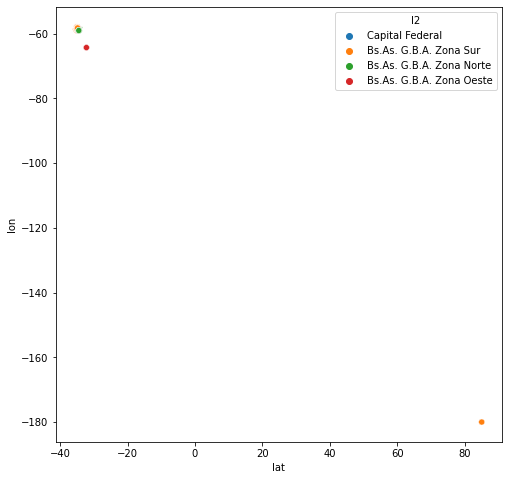

In [ ]:
print('lat media:',data.lat.mean())
print('lon media:',data.lon.mean())
plt.figure(figsize=(8,8))
chart = sns.scatterplot(x='lat',y='lon', data=data, hue='l2')
# plt.scatter(data['lat'],data['lon'])
# plt.title('Scatter lat lon con valores atípicos')
# plt.ylabel('lon')
# plt.xlabel('lat')
plt.show()

Valores atipicos Boxplot

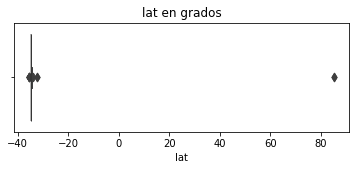

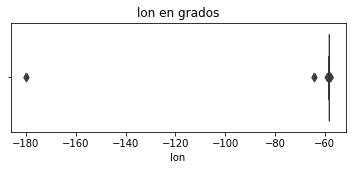

In [ ]:
for t in ['lat','lon']:
  plt.figure(figsize=(6,2))
  char = sns.boxenplot(x=t,data=data)
  char.set_title(t+' en grados')
  plt.show()

Eliminación de valores atípicos de lat y lon por la regla de 3 sigmas.

La ideas es confiar en l3. Subdividimos el dataset agrupado por l3, buscamos y eliminamos los datos atípicos en ese subset.

In [ ]:
coordlist = ['lat','lon']
for l in coordlist:
  filas_pre=data.shape[0]
  print('Filas pre eliminacion', filas_pre)
  for k in data.l3.unique():
    print(k)
    t=data.shape[0]
    data = dropOutlier(data=data, mask=(data['l3']==k), cleancol=l)
    print('Borra: {} filas'.format(t-data.shape[0]))
  print('Se elimiaron:{} filas'.format(filas_pre-data.shape[0]))
print('Filas post eliminacion', data.shape[0])

Filas pre eliminacion 146660
San Cristobal
0.0035200941667224146 -34.632903095154 -34.61178253015367
Borra: 12 filas
Boedo
0.0064640479520181905 -34.647247031681 -34.60846274396889
Borra: 2 filas
Palermo
0.008138229243667245 -34.60971649386319 -34.56088711840118
Borra: 12 filas
La Plata
1.8777695254188576 -40.521058672251186 -29.254441519738037
Borra: 1 filas
Villa Crespo
0.004386934574828986 -34.6119837509866 -34.585662143537625
Borra: 22 filas
Parque Patricios
0.005879060490651453 -34.65300966629569 -34.61773530335178
Borra: 4 filas
Villa Pueyrredón
0.004845338614418381 -34.59911379404484 -34.57004176235833
Borra: 3 filas
Pilar
0.027879466359491824 -34.525075022227 -34.35779822407005
Borra: 67 filas
Tigre
0.022143355290689646 -34.48221095225675 -34.34935082051261
Borra: 141 filas
Abasto
0.006514750495308429 -34.62372789626114 -34.58463939328929
Borra: 9 filas
Flores
0.007944332671141124 -34.652618163217056 -34.604952167190206
Borra: 22 filas
Morón
0.015330549467534062 -34.69210651425

Visualización despues de eliminar valores atípicos.

lat media: -34.60651927299591
lon media: -58.46329013559406


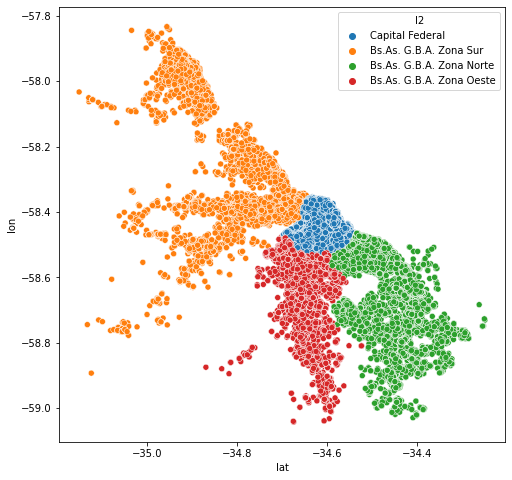

In [ ]:
print('lat media:',data.lat.mean())
print('lon media:',data.lon.mean())
plt.figure(figsize=(8,8))
chart = sns.scatterplot(x='lat',y='lon', data=data, hue='l2')
# plt.scatter(data['lat'],data['lon'])
# plt.title('Scatter lat lon con valores atípicos')
# plt.ylabel('lon')
# plt.xlabel('lat')
plt.show()

El gráficoo se ve mucho mas limpio algunos valores en lat:-34.4, lon:-58.6 al la izquierda parecieran estar sobre el rio. Lamentablemente no se como eliminarlos.

Boxplot lat lon sin valores atípicos

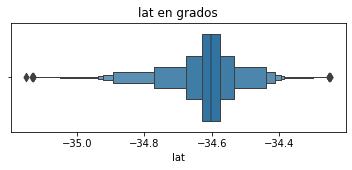

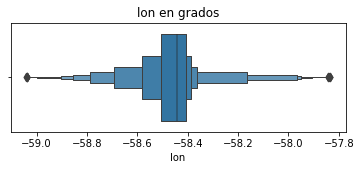

In [ ]:
for t in ['lat','lon']:
  plt.figure(figsize=(6,2))
  char = sns.boxenplot(x=t,data=data)
  char.set_title(t+' en grados')
  plt.show()

####b. Elimino outliers de cuartos, ambientes, baños y superficies.
Elimino outliers de:
* rooms
* bathrooms
* bedrooms
* surface_total 

Esta vez agrupamos las instancias por tipo de propiedad y buscamos los valores atípicos para cada tipo de propiedad. La idea detrás de esto es que la cantidad de habitaciones para un departamento, no es comparable con la de un local comercial oficina o lote.

In [ ]:
cols2clean=['rooms','bathrooms','bedrooms','surface_total','surface_covered']

In [ ]:
def plot_out_rbbss():  
  _i=0
  # f, axes = plt.subplots(len(cols2clean), 1, figsize=(15, 30), sharex=True)
  for col in cols2clean:
    plt.figure(figsize=(15,5))
    # sns.despine(left=True)
    ax = sns.boxplot(x="property_type", y=col, data=data,
                    order=data.groupby('property_type')[col].median().to_frame().reset_index().sort_values(by=col).property_type,
                    )#  ax=axes[_i])
    ax.set_title("Datos atipicos "+col)
    ax.set_xlabel('Tipo de pripiedad')
    ax.tick_params(right=True, top=True, labelright=True, labeltop=True)
    ax.set_ylabel(col)
    _i=_i+1
    plt.show()



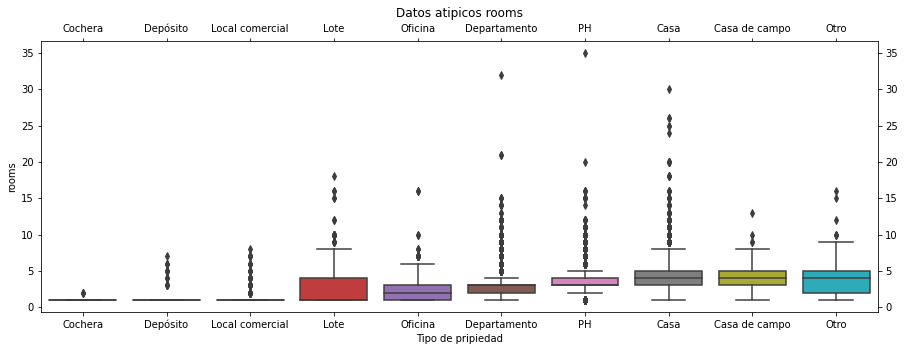

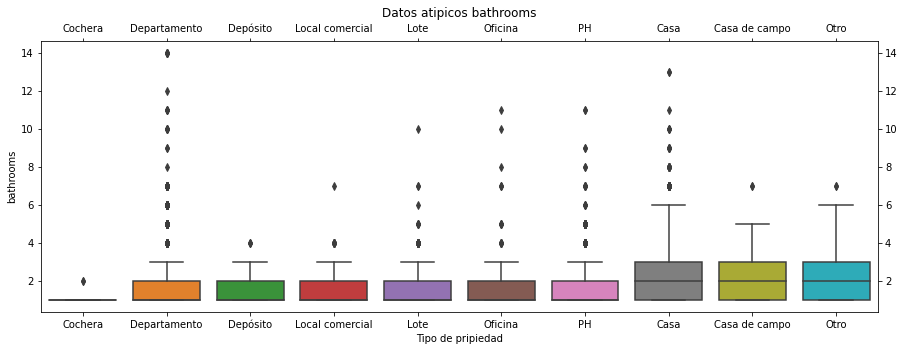

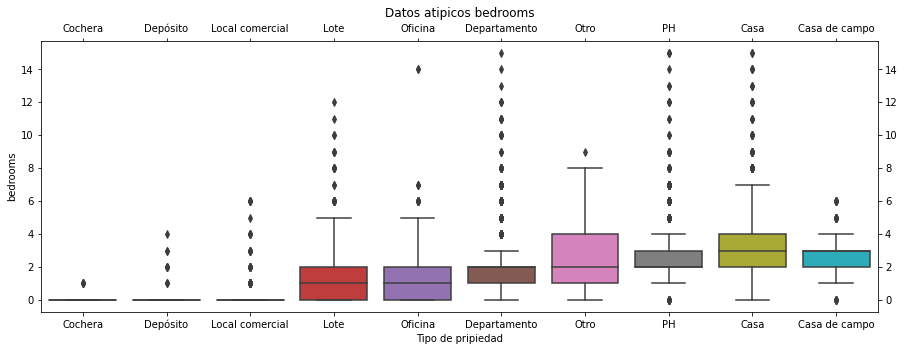

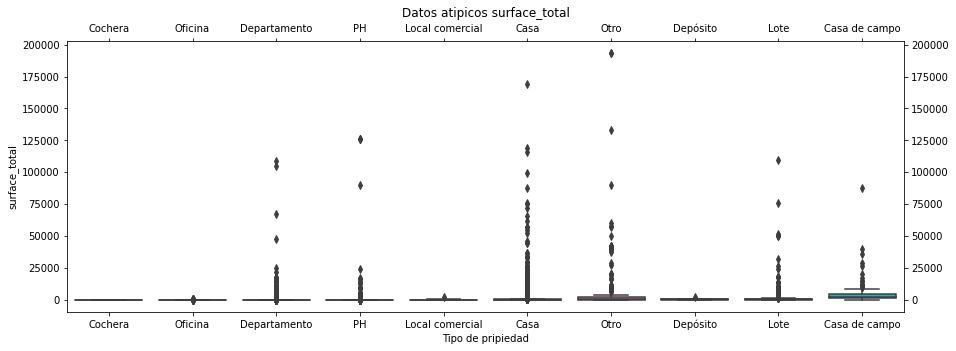

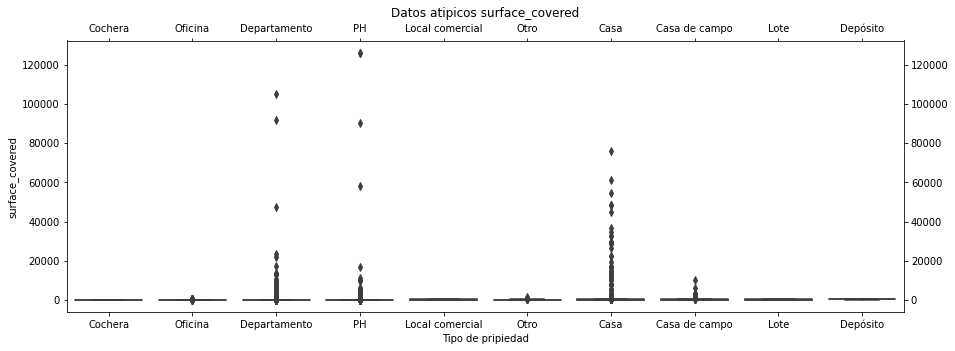

In [ ]:
plot_out_rbbss()

Filas pre eliminacion 145069
1.3508739598940778 -0.5215319536719885 7.583711805692477
1.1447490985391267 -0.6782722756615178 6.1902223155732425
1.5766243773802546 -0.22714917553457692 9.23259708874695
2.1770260530127814 -4.217015659038344 8.845140659038345
1.5044935030766142 -0.33399332974266294 8.692967688717022
1.8336670780658038 -3.1271550803512573 7.874847388043565
2.309117257741731 -3.0901424708996124 10.764561075550775
1.3747252178489027 -2.5437340131681587 5.704617293925256
0.10741237092759398 0.6893907941939623 1.333865019759526
0.933689621788859 -1.5685107258316933 4.033627004901461
Se elimiaron:1229 filas
Filas pre eliminacion 143840
0.6687247929717701 -0.5563501773331245 3.4559985804974964
0.7938166035593247 -0.8846261226645511 3.8782734986913967
1.076553234365317 -1.1159328110522373 5.343386595139664
0.8850526827926007 -0.9490077066921532 4.361308390063451
0.9083913392227081 -0.7251740176681243 4.725174017668124
0.9957714712529976 -1.5173896017289177 4.457239225789068
1.165

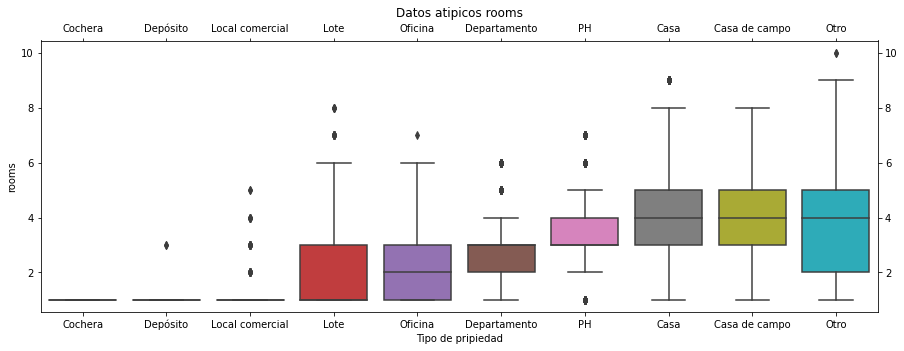

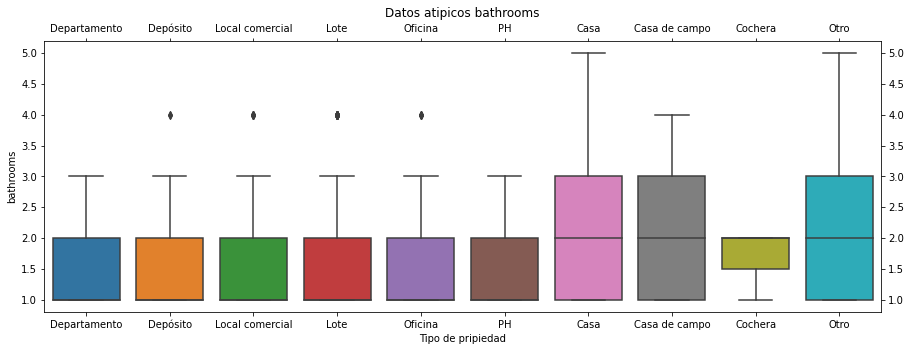

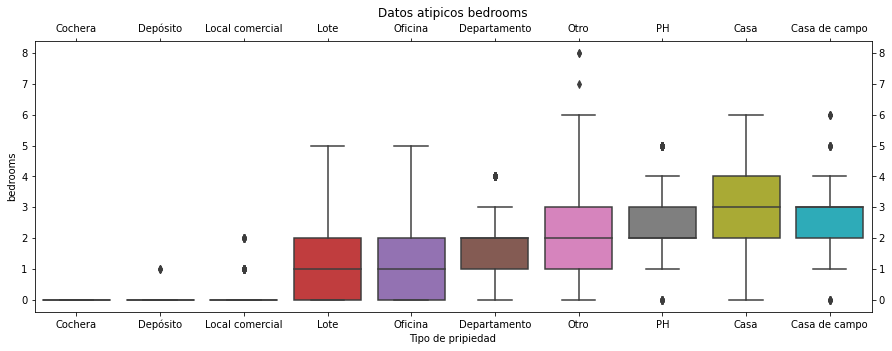

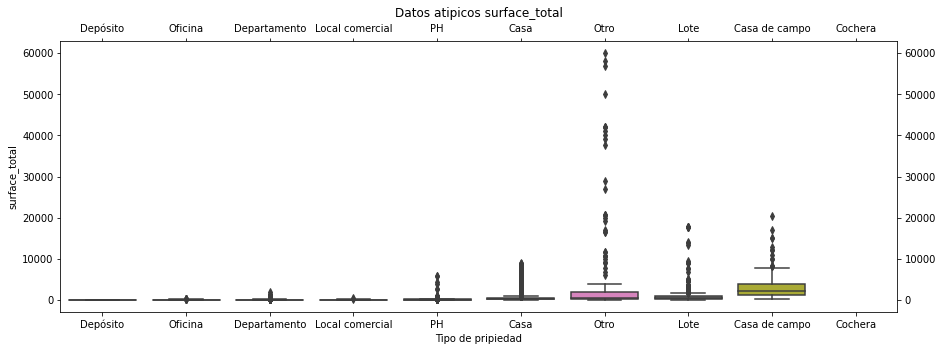

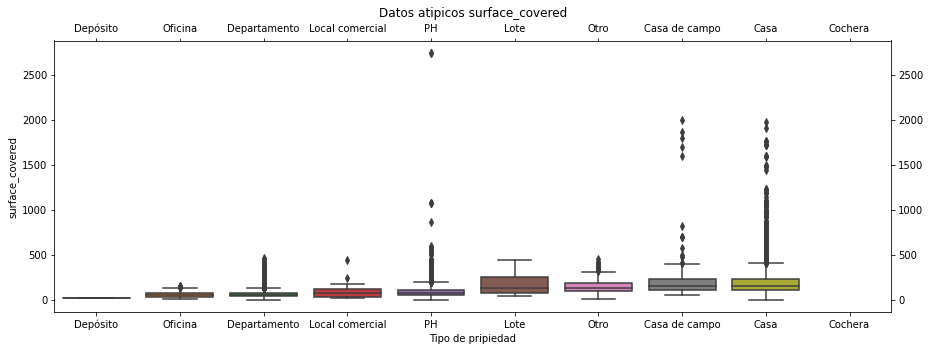

In [ ]:

for l in cols2clean:
  filas_pre=data.shape[0]
  print('Filas pre eliminacion', filas_pre)
  for k in data.property_type.unique():
    data = dropOutlier(data=data, mask=(data['property_type']==k), cleancol=l)
  print('Se elimiaron:{} filas'.format(filas_pre-data.shape[0]))
print('Filas post eliminacion', data.shape[0])
plot_out_rbbss()

Corroboramos con los siguientes gráficos de boxplot que los datos atipicos, si no desaparecieron por lo menos fueron minimizados.

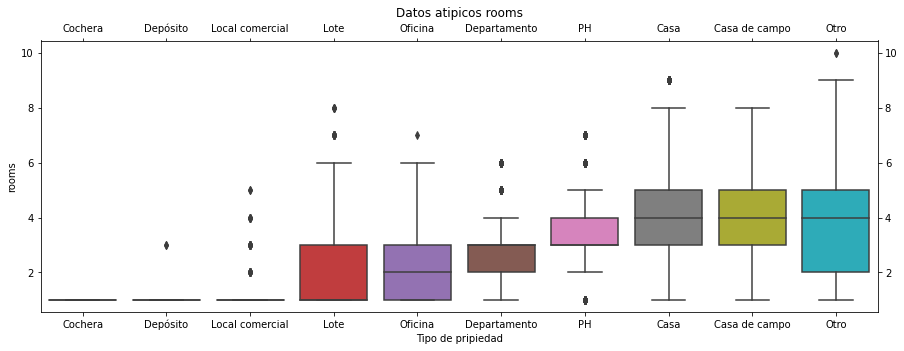

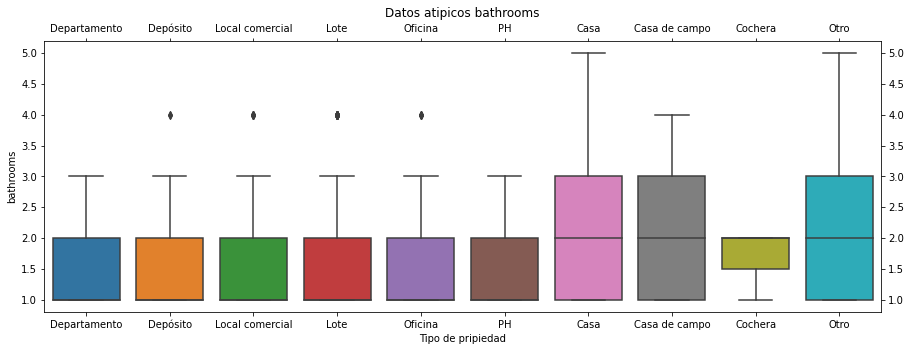

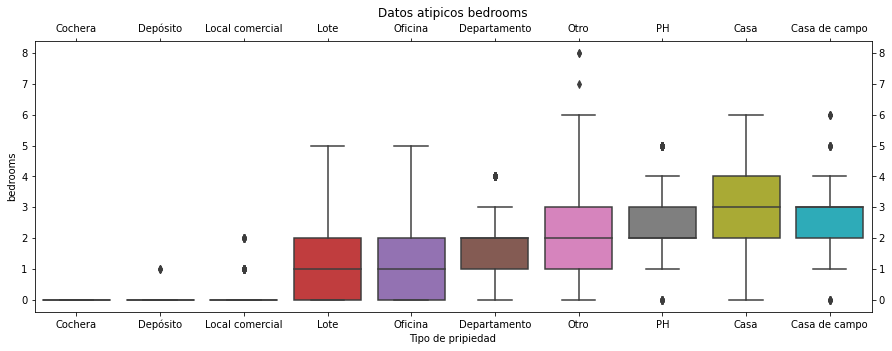

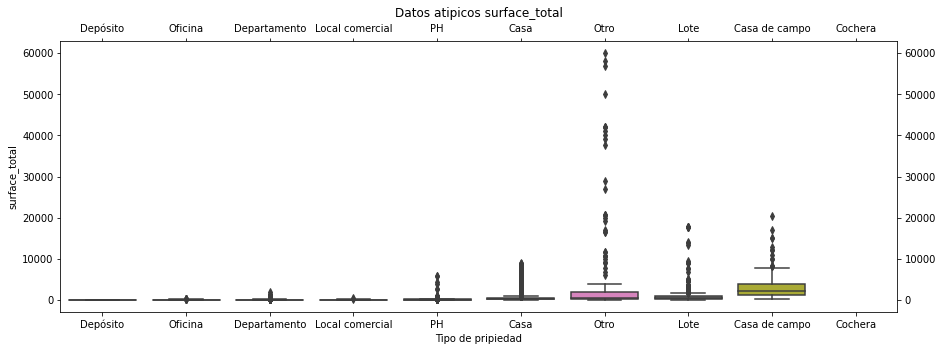

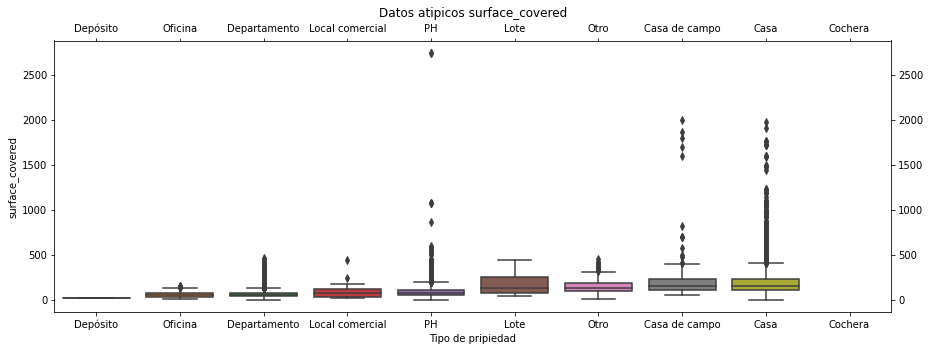

In [ ]:
plot_out_rbbss()

####c. Elimo outlier de precio agrupados por tipo de propiedad

Nuevamente, aquí tratamos de eliminar los valores atípicos para instancias parecidas.

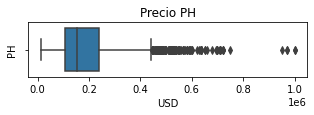

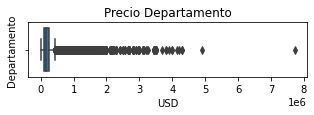

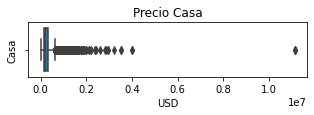

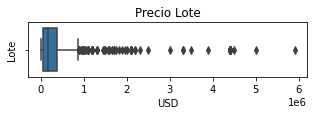

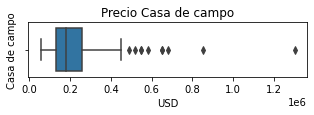

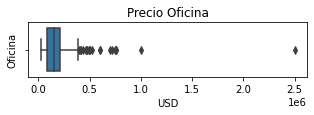

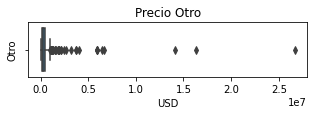

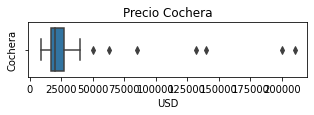

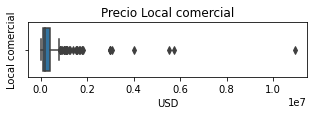

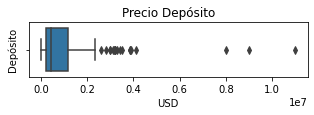

In [ ]:
for pt in data.property_type.unique():
  plt.figure(figsize=(5,1))
  ax= sns.boxplot(x='price', data=data[data.property_type==pt])
  ax.set_title("Precio "+pt)
  ax.set_xlabel('USD')
  ax.set_ylabel(pt)
  plt.show()

Los scater plots siguientes tratan de visualizar los outlier del precio en relación a la superficie total, Se hace muy difícil identificarlos porque la dispersión del precio del m2 es amplia. Esto se puede ver por ejemplo en el gráfico property_type = Departamento, donde el precio crece pegado al eje y, es decir para las mismas dimensiones todos los rangos de precio. 
O para property_type = Departamento donde el gráfico tiene forma de L, donde para algunas instancias el precio sube pegado al eje 'y' en cambio para otras el precio se mantiene aunque aumentan los metros cubiertos o totales.

Lo que uno esperaría es una correlación más fuerte,  visible, y que el precio aumente junto con los m2.
Entiendo que la naturaleza de estos scaters es así porque más allá del estado o calidad de la construcción, el precio del m2 de propiedad varía según la zona geográfica.


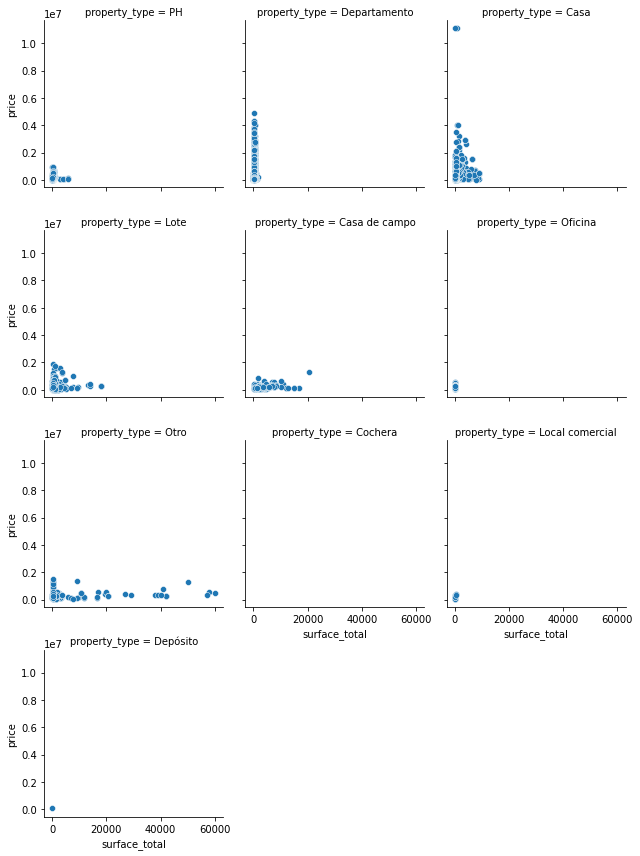

In [ ]:
g = sns.FacetGrid(data,  col="property_type", col_wrap=3)
g.map(sns.scatterplot, 'surface_total', "price")
plt.show()

In [ ]:
filas_pre=data.shape[0]
for k in data.property_type.unique():
  data = dropOutlier(data=data, mask=(data['property_type']==k), cleancol='price')
print('Se elimiaron:{} filas'.format(filas_pre-data.shape[0]))
print('Filas post eliminacion', data.shape[0])

102162.1711184005 -125088.03494988586 487884.99176051706
200077.41337496552 -390661.99357065145 809802.4866791416
251264.59902230455 -489958.4332353615 1017629.1608984659
714551.5073582012 -1762271.3133367393 2525037.7308124676
129105.70044671869 -178213.7680068227 596420.4346734894
147433.93400553273 -272955.0442424574 611648.5597907389
2038339.1497239883 -5422636.161293177 6807398.737050753
20944.290730495115 -38359.459493072645 87306.28488989804
914364.3927232955 -2303947.051890023 3182239.30444975
1306775.7875457276 -2992170.98403636 4848483.741238005
Se elimiaron:2171 filas
Filas post eliminacion 137719


Vemos en los boxplot que la cantidad de instancias más allá de los bigotes disminuyen.

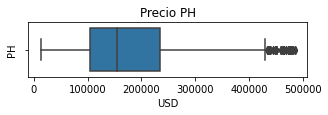

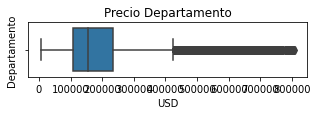

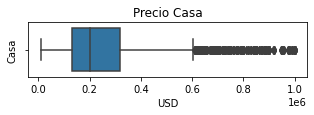

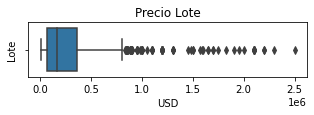

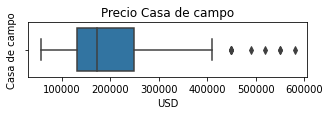

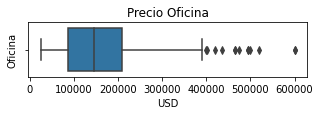

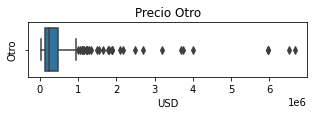

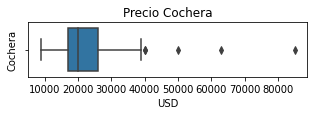

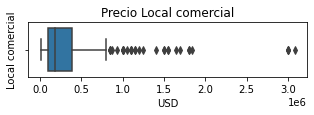

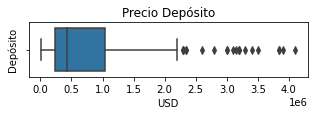

In [ ]:
for pt in data.property_type.unique():
  plt.figure(figsize=(5,1))
  ax= sns.boxplot(x='price', data=data[data.property_type==pt])
  ax.set_title("Precio "+pt)
  ax.set_xlabel('USD')
  ax.set_ylabel(pt)
  plt.show()

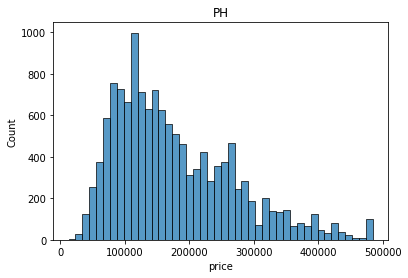

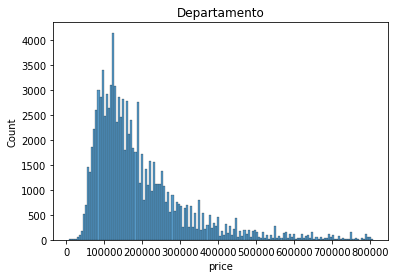

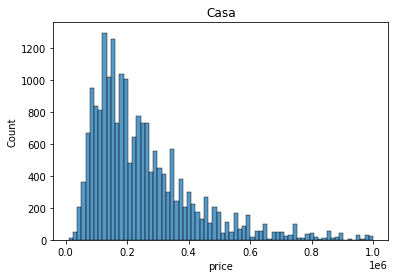

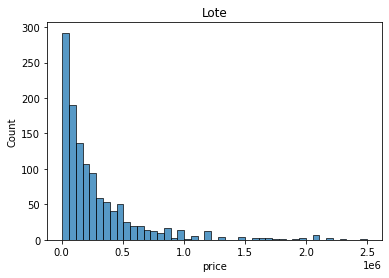

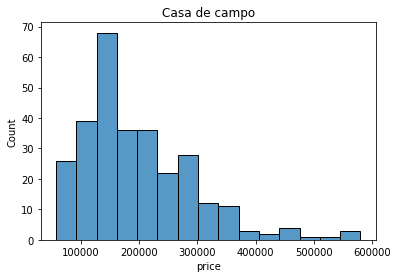

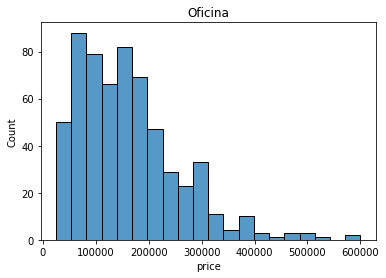

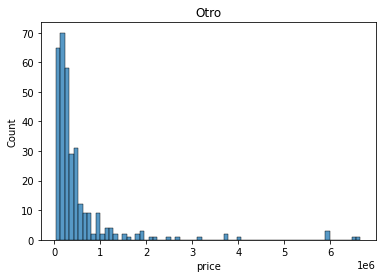

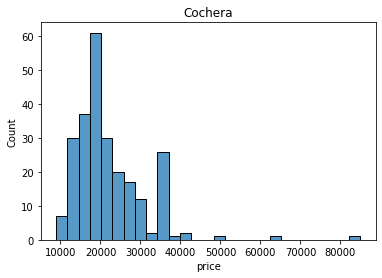

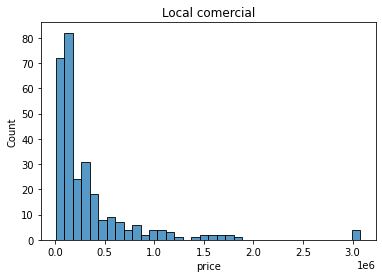

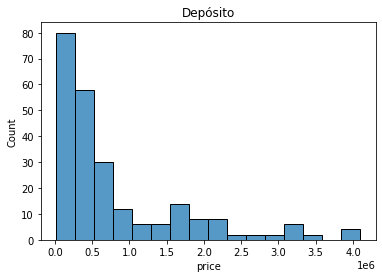

In [ ]:
for pt in data.property_type.unique():
  char=sns.histplot(data[(data.property_type==pt)].price)
  # char.set_titles(pt)
  char.set_title(pt)
  plt.show()

####Correlación

In [ ]:
data.drop(columns=['lat','lon']).groupby(['property_type']).describe()

rooms                      ...     price                      
                    count      mean       std  ...       50%        75%        max
property_type                                  ...                                
Casa              20272.0  4.371448  1.313083  ...  200000.0   320000.0  1000000.0
Casa de campo       292.0  4.068493  1.314249  ...  172500.0   250000.0   580000.0
Cochera             248.0  1.000000  0.000000  ...   20000.0    26000.0    85000.0
Departamento     100861.0  2.640951  0.988168  ...  155000.0   235000.0   808400.0
Depósito            240.0  1.016667  0.182192  ...  435000.0  1032500.0  4100000.0
Local comercial     289.0  1.273356  0.748621  ...  180000.0   389000.0  3078785.0
Lote               1206.0  2.110282  1.710192  ...  165000.0   360000.0  2500000.0
Oficina             604.0  2.142384  1.397555  ...  145000.0   209960.0   600000.0
Otro                327.0  3.672783  2.025897  ...  255000.0   482500.0  6653528.0
PH                13380.0  3.380717  1.043082  ...  155000.0   235000.0   485000.0

[10 rows x 48 columns]

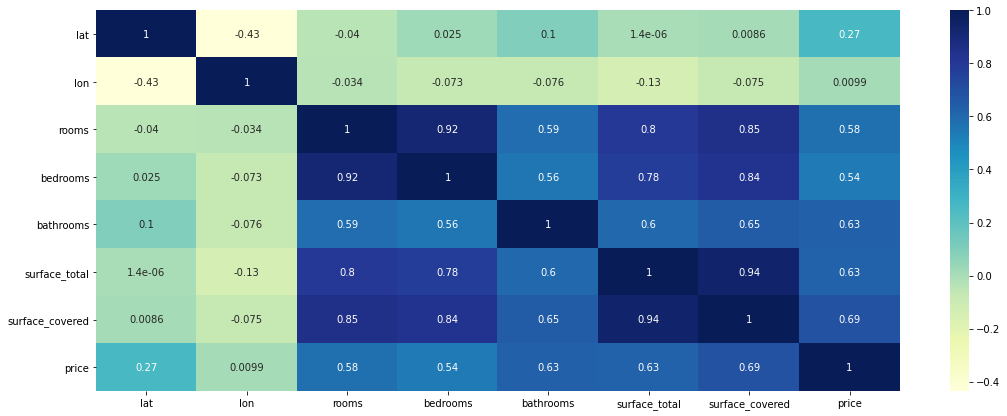

In [ ]:
corr=data.corr('spearman')
plt.figure(figsize=(18,7))
sns.heatmap(corr, cbar = True, annot = True, cmap='YlGnBu')
plt.show()

###3. Imputación de valores faltantes

####Revisos Valores Nulos

Ahora que ya eliminamos los valores atípicos.


In [ ]:
vacios=data.isnull().sum()
vacios=vacios.drop(vacios[vacios == 0].index)
pd.DataFrame({'Valores Faltantes' :vacios})

Valores Faltantes
lat                           9066
lon                           9098
bathrooms                     5714
surface_total                19631
surface_covered              20598

Revisamos tambien si hay valores en 0 donde no debería haberlo. 

In [ ]:
pd.DataFrame({'Valores en Cero' : (data == 0).astype(int).sum(axis=0)})

Valores en Cero
lat                            0
lon                            0
l2                             0
l3                             0
rooms                          0
bedrooms                    6929
bathrooms                      0
surface_total                  0
surface_covered                0
price                          0
title                          0
description                    0
property_type                  0

In [ ]:
data[data.bedrooms == 0].groupby('property_type').property_type.count().reset_index(name='count')

property_type  count
0             Casa   1401
1    Casa de campo      9
2          Cochera    248
3     Departamento   3940
4         Depósito    237
5  Local comercial    250
6             Lote    561
7          Oficina    199
8             Otro     70
9               PH     14

El feature bedrooms está en 0 en para instancias donde el tipode propiedad nos insinúa que no debería. Este feature tiene una relación fuerte con la variable target.Una opción sería ponerlo en nan e imputar con knn u otro método. Por otro lado podrían ser monoambientes por ejemplo.Vamos a dejar esta variable sin tocar, pero puede estar sumando ruido y malogrando el mejor resultado en la predicción.

In [ ]:
pd.DataFrame({'Porcentaje' :(vacios/data.shape[0])*100})

Porcentaje
lat                6.582970
lon                6.606205
bathrooms          4.149028
surface_total     14.254388
surface_covered   14.956542

#### lat y lon por media de l3

Scatter de la medias de lat y lon por barrio (l3)

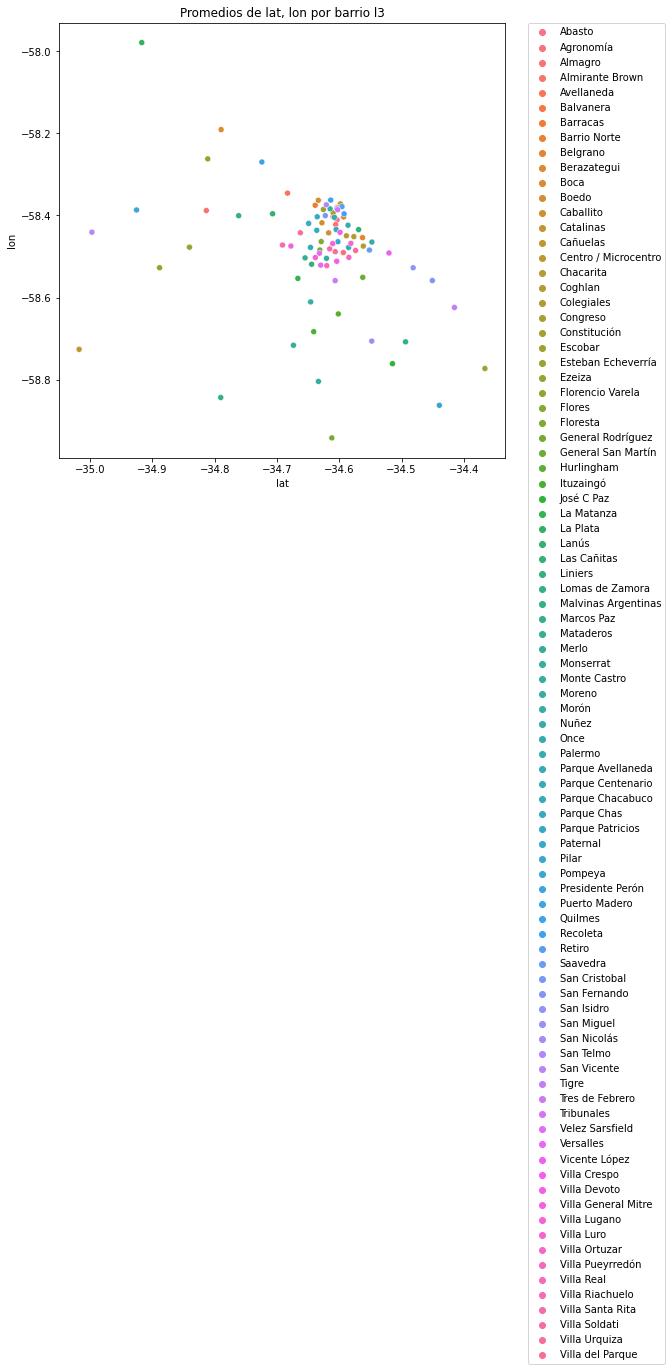

In [ ]:
gr=data.groupby(["l3"])
# display(gr[['l3','lat','lon']].mean())
# display(gr.lat.transform("mean"))
t=gr[['l3','lat','lon']].mean().reset_index()
plt.figure(figsize=(8,8))
sns.scatterplot(x='lat', y='lon', data=t, hue='l3')
plt.title('Promedios de lat, lon por barrio l3')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

Imputación de lat, media por barrio.

Otra vez recurrimos a confiar en l3, e imputamos lat y lon por la media que conseguimos agrupando las instacias por l3.



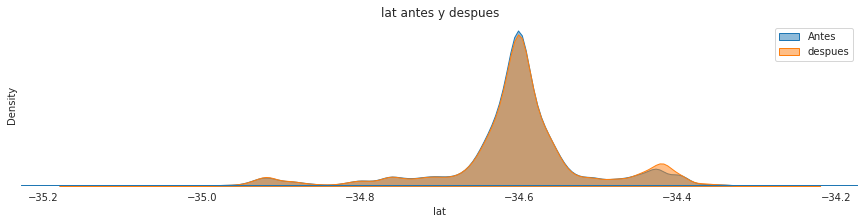

In [ ]:
# sns.set(style='white', rc={"axes.facecolor": (0, 0, 0, 0),'legend.frameon':True})
sns.set_style('white', {'legend.frameon':True})
palette=['#4285F4', '#DB4437', '#0F9D58']
plt.figure(figsize=(15,3))
plt.axhline(lw=3)
chart = sns.kdeplot(x='lat', label='Antes',data=data,alpha=0.5, shade=True, palette=palette)
chart.set_label('antes')
data["lat"].fillna(gr.lat.transform("mean"),inplace=True)
chart = sns.kdeplot(x='lat', label='despues', data=data,alpha=0.5, shade=True, palette=palette)
chart.set(yticks=[])
chart.set_title('lat antes y despues')
chart.set_label('despues')
sns.despine(bottom=True, left=True)
plt.legend()
plt.show()
sns.set()

Verificamos que la distribución se mantenga despues de la imputación de lat.

Imputación de lon, media por barrio

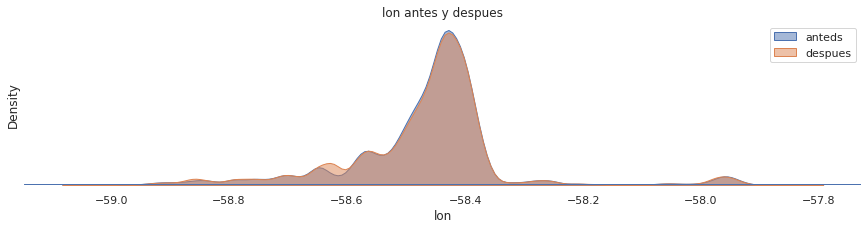

In [ ]:
sns.set_style('white', {'legend.frameon':True})
plt.figure(figsize=(15,3))
plt.axhline(lw=3)
chart = sns.kdeplot(x='lon', label='anteds',data=data,alpha=0.5, shade=True, palette=palette)
chart.set_label('antes')
data["lon"].fillna(gr.lon.transform("mean"),inplace=True)
chart = sns.kdeplot(x='lon', label='despues', data=data,alpha=0.5, shade=True, palette=palette)
chart.set(yticks=[])
chart.set_title('lon antes y despues')
chart.set_label('despues')
sns.despine(bottom=True, left=True)
plt.legend()
plt.show()
sns.set()


Comprobamos que la dsitribucion de lon no se mantenga despues de la imputación.

Rechequeamos los valores faltantes a ver si la imputación fue exitosa.


In [ ]:
data.isna().sum().reset_index(name='NaNs')
vacios=data.isnull().sum()
vacios=vacios.drop(vacios[vacios == 0].index)
pd.DataFrame({'Valores Faltantes' :vacios})

Valores Faltantes
bathrooms                     5714
surface_total                19631
surface_covered              20598

#### Eliminación de impurezas

Aqui revisamos aquellas cosas que estan mal o fuera de lugar.

Filas Duplicadas

In [ ]:
data.drop_duplicates(keep='first').shape
data[data.duplicated(keep='first')].shape

(27261, 13)

In [ ]:
# data[data.duplicated(keep=False)].sort_values(['lat','lon','rooms','bedrooms','bathrooms'])
duplicadas_totales=data[data.duplicated(keep=False)]
duplicadas_unicas=data[data.duplicated(keep='first')]
print('Duplicados Totales: ', duplicadas_totales.shape[0],
      '\nFilas Unicas con duplicados: ',duplicadas_totales.shape[0]-duplicadas_unicas.shape[0],
      '\nFilas candidatas a eliminar: ',duplicadas_unicas.shape[0])
print('\nDuplicados (unicas + duplicados) por tipo de propiedad:')
display(data[data.duplicated(keep=False)].groupby('property_type').property_type.count().reset_index(name='count'))
print('\nFilas duplicados candidatas a borrado por tipo de propiedad:')
display(
    data[data.duplicated(keep='first')].groupby('property_type').property_type.count().reset_index(name='count')
    )


Duplicados Totales:  38965 
Filas Unicas con duplicados:  11704 
Filas candidatas a eliminar:  27261

Duplicados (unicas + duplicados) por tipo de propiedad:


property_type  count
0           Casa    644
1  Casa de campo     25
2   Departamento  34056
3           Lote     25
4        Oficina    117
5           Otro      2
6             PH   4096


Filas duplicados candidatas a borrado por tipo de propiedad:


property_type  count
0           Casa    361
1  Casa de campo     18
2   Departamento  23815
3           Lote     15
4        Oficina     60
5           Otro      1
6             PH   2991

La inspección la descripción revela que ejemplo departamentos vendidos desde pozo (ej: "Venta de Departamento en Pozo con Financiación ROBLES DE SAN VICENTE"), podria significad ventas de varias propiedades identicas, por lo que es lógico encontrar mas de una instancia, lo mismo podria suceder con locales comerciales o loteos, PHs (duplex), por lo que no los voy a eliminar dado que requieren un estudio más prufundo.

In [ ]:
data[
     data.duplicated(keep='first') & (data.property_type!='1PH') & (data.surface_total.isna()) & (data.surface_covered.isna())
     ].sort_values(
         ['lat','lon','rooms','bedrooms','bathrooms','title']
         )[['property_type','title','description']]

property_type  ...                                        description
92677           Casa  ...  Xintel (FTP-FTP-116) Venta de Casa 2 DORMITORI...
116902          Casa  ...  Xintel (FTP-FTP-116) Venta de Casa 2 DORMITORI...
83554   Departamento  ...  Venta de Departamento 3 AMBIENTES en Fincas de...
83555   Departamento  ...  Venta de Departamento 3 AMBIENTES en Fincas de...
83556   Departamento  ...  Venta de Departamento 3 AMBIENTES en Fincas de...
...              ...  ...                                                ...
86532   Departamento  ...  DEPARTAMENTO  EN VENTA  | BOUQUET  - Pilar  | ...
86526   Departamento  ...  DEPARTAMENTO  EN VENTA / ALQUILER  | BOUQUET  ...
86527   Departamento  ...  DEPARTAMENTO  EN VENTA  | BOUQUET  - Pilar  | ...
86533   Departamento  ...  DEPARTAMENTO  EN VENTA  | BOUQUET  - Pilar  | ...
86596   Departamento  ...  DEPARTAMENTO  EN VENTA  | BOUQUET  - Pilar  | ...

[499 rows x 3 columns]

In [ ]:
pd.set_option('display.max_colwidth', None)
pd.set_option("display.max_rows", 200)
display(data[data.duplicated(keep=False) & (data.property_type!='1PH')]
        .sort_values(['lat','lon','rooms','bedrooms','bathrooms','title'])
        [['property_type','title','description']].head(400))
pd.set_option('display.max_colwidth', 65)

property_type  ...                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              description
32934   Departamento  ...  Departamento en venta de dos dormitorios ubicado en Club de Campo Haras del Sur I uno de los barrios mas conformados de la zona,Desarrollado en planta baja  sobre una superficie de 160m2 con una superficie cubierta de 90m2 .cuenta con 2 dormitorios, 1 baño, living y cocina comedor completa con estantes alacena y bajo mesada. cuenta con sistema de cerramiento de vidrio en galería, con parrilla y mesada. equipos frío calor en todos los ambientes, apto para vivienda y compra por crédito hipotecario. El complejo posee pileta exclusiva del condominio de 7 x 14 mts y sum con vestuarios. Además brinda los servicios y amenities del club de campo.En Haras del Sur  encontrara áreas sociales y deportivas rodeadas de naturaleza, diseñadas para que toda la familia pueda disfrutar. Se destaca por la Cancha de Golf PAR 3, la infraestructura hípica y la maravillosa laguna de 6 hectáreas. Su añosa arboleda nos invita a recorrerla junto a nuestra familia y amigos.Los servi

Elimino porpiedades con superficie cubierta mayor a superficie total

In [ ]:
print("Se eliminan ",data[(data.surface_total < data.surface_covered)].shape[0]," filas")
data=data[~(data.surface_total < data.surface_covered)]
# display(data[(data.surface_total < data.surface_covered)])

Se eliminan  1274  filas


Propiedades con con cuartos (bedrooms) mayor a ambientes (rooms)

In [ ]:
print("Se eliminan ",data[(data.rooms < data.bedrooms)].shape[0]," filas")
data=data[~(data.rooms < data.bedrooms)]

Se eliminan  100  filas


Elimino viviendas con superficie cubierta menor a 18 m2, que es el minimo segun el codigo de viviendas de caba

http://clavesdeco.puraciudad.com.ar/como-son-los-nuevos-micro-departamentos-de-buenos-aires/#:~:text=El%20nuevo%20C%C3%B3digo%20de%20Edificaci%C3%B3n%20autoriza%20la%20construcci%C3%B3n%20de%20departamentos,superficie%20m%C3%ADnima)%20y%20un%20ba%C3%B1o.

In [ ]:
data=data[~(data.property_type.isin(['Casa','Departamento','PH','Casa de Campo']) & (data.surface_covered < 18))]

In [ ]:
display(data[data.surface_covered < 15].groupby(by=['property_type']).count())
      
display(data.groupby(by=['property_type']).size())

lat  lon  l2  l3  ...  surface_covered  price  title  description
property_type                    ...                                            
Oficina          5    5   5   5  ...                5      5      5            5
Otro             1    1   1   1  ...                1      1      1            1

[2 rows x 12 columns]

property_type
Casa               19694
Casa de campo        292
Cochera              248
Departamento       99976
Depósito             240
Local comercial      287
Lote                1202
Oficina              603
Otro                 325
PH                 13263
dtype: int64

#### Inputa bathrooms, media por numero de ambientes

In [ ]:
data.groupby(by=['bedrooms']).bathrooms.transform("mean")
data["bathrooms"].fillna(data.groupby(by=['bedrooms']).bathrooms.transform("mean"), inplace=True)
#me queda una fila con NaN
data["bathrooms"].fillna(data[data.bedrooms==6].bathrooms.mean(),inplace=True)

In [ ]:
data.bathrooms=data.bathrooms.astype(int)

#### Imputacion de superficie total y superficie cubierta

Cantidad de valores faltantes versus la cantidad de instancias de cada tipo de propiedad

In [ ]:
# data[data.surface_total.isna()].groupby(['property_type']).surface_covered.sum()
# data.isna().groupby(['property_type']).sum()
display(data.groupby(['property_type']).apply(lambda x: x.isna().sum())[['surface_total','surface_covered']]
        .join(
            data.groupby(['property_type']).property_type.describe()[['count']]
        ).reset_index()
        
        )


property_type  surface_total  surface_covered  count
0             Casa           4703             4653  19694
1    Casa de campo             61               61    292
2          Cochera            248              248    248
3     Departamento          12981            13311  99976
4         Depósito            239              239    240
5  Local comercial            276              277    287
6             Lote            566             1179   1202
7          Oficina            244              260    603
8             Otro            139              224    325
9               PH            105              141  13263

In [ ]:
data.groupby(['property_type'])[['surface_total','surface_covered','price']].describe().transpose()

property_type                    Casa  ...             PH
surface_total   count    14991.000000  ...   13158.000000
                mean       463.311987  ...     121.175255
                std        556.651439  ...     118.467460
                min         25.000000  ...      20.000000
                25%        200.000000  ...      68.000000
                50%        300.000000  ...     102.000000
                75%        525.000000  ...     146.000000
                max       9017.000000  ...    5821.000000
surface_covered count    15041.000000  ...   13122.000000
                mean       180.703544  ...      89.159960
                std        113.277996  ...      58.647960
                min         21.000000  ...      20.000000
                25%        110.000000  ...      55.000000
                50%        155.000000  ...      78.000000
                75%        220.000000  ...     110.000000
                max       1912.000000  ...    2748.000000
price           count    19694.000000  ...   13263.000000
                mean    247894.717630  ...  176704.968031
                std     165068.153414  ...   92549.659839
                min      10000.000000  ...   13000.000000
                25%     130000.000000  ...  105000.000000
                50%     200000.000000  ...  155000.000000
                75%     320000.000000  ...  235000.000000
                max    1000000.000000  ...  485000.000000

[24 rows x 10 columns]

###### Cocheras

No hay ni una instacia con valores de superficies completo, las dimesiones minimas de una cochera en CABA es de 5 x 2,5 metros. "Una cochera es una cochera." 15m2 aporx.
Claro que aqui podria existir alguna instancia que la cochera sea para mas de un auto.

Fuente:http://www.buenosaires.gob.ar/sites/gcaba/files/anexo_ii_pet.pdf

In [ ]:
mask=data.property_type=='Cochera'
data[['surface_total','surface_covered']]=data[['surface_total','surface_covered']].mask(mask, data[['surface_total','surface_covered']].fillna(15))  

##### Locales comercial y Depósito

In [ ]:
pt_list=['Local comercial','Depósito']
data_tmp=data[data.property_type.isin(pt_list)]
display(data_tmp.groupby(['property_type']).apply(lambda x: x.isna().sum())[['surface_total','surface_covered']]
        .join(
            data_tmp.groupby(['property_type']).property_type.describe()[['count']]
        )
        
        )


surface_total  surface_covered count
property_type                                        
Depósito                   239              239   240
Local comercial            276              277   287

Si bien podriamos intentar usar knnimputer dado que no hay casi no hay datos con la variable target no sería para nada efectiva. Por lo tanto elimino las filas para estos dos tipos tipos de propiedad.

In [ ]:
data=data[~data.property_type.isin(pt_list)]

##### Otros

In [ ]:
pt_list=['Otro']
pd.set_option('display.max_colwidth', None)
pd.set_option("display.max_rows", None)
data[data.property_type.isin(pt_list)].title
pd.set_option('display.max_colwidth', 65)
pd.set_option("display.max_rows", 65)

La columna Otros contiene cualquier tipo de propiedad, es imposiblre conseguir una prediccion correcta sin hacer un trabajo exaustivo con la columna titulo y descripción. Eliminamos estas instancias.

In [ ]:
data=data[~data.property_type.isin(pt_list)]

##### Test IterativeImputer


###### KNN vs RandomForest
Comparo el desempeño de KNNRegressor, que utiliza KNNRegressor contra RandomForestRegressor, que se puede utilizar mediante IterativeImputer.

La idea es correr un cross validation entre estos dos modelos con el dataset si los valores nan, a ver que tal se comporta y que podemos esperar utilizando dichos modelos como imputadores.

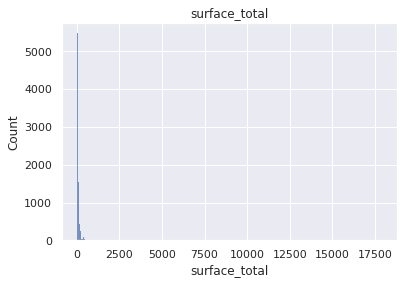

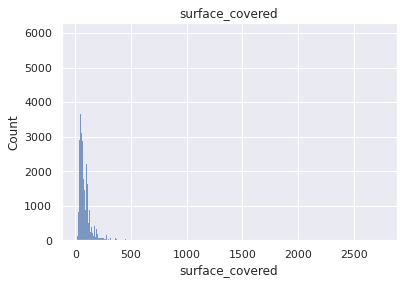

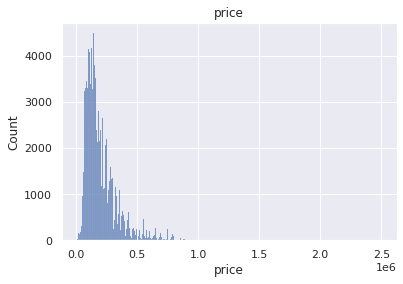

In [ ]:
for feat in ['surface_total','surface_covered','price']:
  chart = sns.histplot(x=feat,data=data)
  chart.set_title(feat)
  plt.show()

Aplicando log1p para corregir la asimentría.

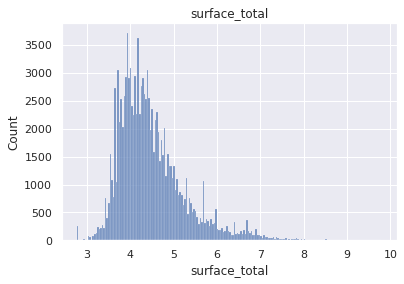

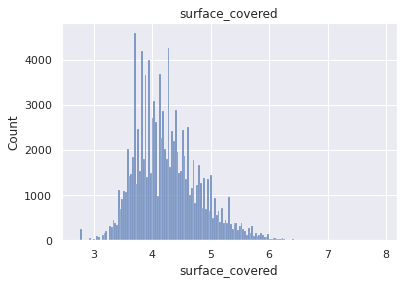

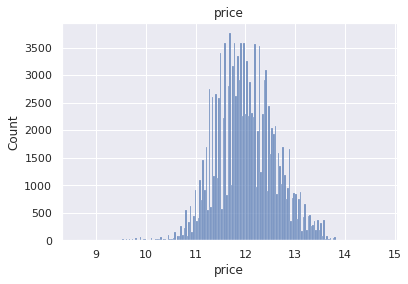

In [ ]:
for feat in ['surface_total','surface_covered','price']:
  chart = sns.histplot(x=np.log1p(data[feat]))
  chart.set_title(feat)
  plt.show()

In [ ]:
%%time
def test_scorer(descr='',score=[]):
    return {
        'Descripcion':descr,
        'R2': score.mean(),
        'R2std': score.std(),
    }



scores=pd.DataFrame()
scaler=RobustScaler()
rgs_rf=RandomForestRegressor(random_state=42,n_jobs=-1)
rgs_knn=KNeighborsRegressor()
data_tmp=data.dropna() # copio el dataframe a un temporal para la experimentación
data_tmp=data_tmp[data_tmp.l2=='Capital Federal'] # subset de pureba
data_tmp.drop(columns=['title','description'],inplace=True)
data_tmp=pd.get_dummies(data_tmp)
data_tmp=pd.DataFrame(scaler.fit_transform(data_tmp),index=data_tmp.index,columns=data_tmp.columns)

## Evaluo suface total
X=data_tmp.drop(columns=['surface_total','surface_covered'])
y=data_tmp['surface_total']

### cross_val_score con RF
score=cross_val_score(
    rgs_rf, X, y, scoring='r2',
    cv=CV,verbose=VERBOSE
)

scores=scores.append(test_scorer('Surface_total RandomForest',score), ignore_index=True)

score=cross_val_score(
    rgs_knn, X, y, scoring='r2',
    cv=CV,verbose=VERBOSE, n_jobs=-1
)

scores=scores.append(test_scorer('Surface_total Knn',score), ignore_index=True)

## Evaluo surface covered
X=data_tmp.drop(columns=['surface_total','surface_covered'])
y=data_tmp['surface_covered']

score=cross_val_score(
    rgs_rf, X, y, scoring='r2',
    cv=CV,verbose=VERBOSE
)

scores=scores.append(test_scorer('Surface_covered RandomForest',score), ignore_index=True)

score=cross_val_score(
    rgs_knn, X, y, scoring='r2',
    cv=CV,verbose=VERBOSE, n_jobs=-1
)

scores=scores.append(test_scorer('Surface_covered Knn',score), ignore_index=True)


[CV]  ................................................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] .................................... , score=0.470, total=  25.0s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   25.0s remaining:    0.0s


[CV] .................................... , score=0.450, total=  23.9s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   48.9s remaining:    0.0s


[CV] .................................... , score=0.755, total=  23.9s


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  1.2min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  1.2min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   12.4s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   12.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  ................................................................
[CV] .................................... , score=0.891, total=  23.7s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   23.7s remaining:    0.0s


[CV] .................................... , score=0.834, total=  23.5s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   47.2s remaining:    0.0s


[CV] .................................... , score=0.890, total=  23.7s


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  1.2min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  1.2min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


CPU times: user 9.23 s, sys: 1.21 s, total: 10.4 s
Wall time: 2min 48s


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   12.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   12.2s finished


Estos son los resultados de la predicciones con los datos escalados.

In [ ]:
scores

Descripcion        R2     R2std
0    Surface_total RandomForest  0.558360  0.139442
1             Surface_total Knn  0.480040  0.081239
2  Surface_covered RandomForest  0.871742  0.026469
3           Surface_covered Knn  0.756290  0.009702

Se puede apreciar que los valores del error son bastante pobres, sobre todod para la variable target surface_total.

Repetimos el entrenamiento y la evaluación pero esta vez utilizando log1p para las varialbles target surface total y surface covered. Aplicamos log1p por que estas variables target denotan una marcad asimetria negativa en la distribución.

In [ ]:
## Evaluación con datos escalados y log1p de las varialbes target
data_tmp=data.dropna() # copio el dataframe a un temporal para la experimentación
data_tmp=data_tmp[data_tmp.l2=='Capital Federal'] # subset de pureba
data_tmp.drop(columns=['title','description'],inplace=True)
data_tmp=pd.get_dummies(data_tmp)
data_tmp.surface_covered=np.log1p(data_tmp.surface_covered)
data_tmp.surface_total=np.log1p(data_tmp.surface_total)
data_tmp=pd.DataFrame(scaler.fit_transform(data_tmp),index=data_tmp.index,columns=data_tmp.columns)

## Evaluo suface total
X=data_tmp.drop(columns=['surface_total','surface_covered'])
y=data_tmp['surface_total']

### cross_val_score con RF
score=cross_val_score(
    rgs_rf, X, y, scoring='r2',
    cv=CV,verbose=VERBOSE
)

scores=scores.append(test_scorer('Surface_total RandomForest log1p v.target',score), ignore_index=True)

score=cross_val_score(
    rgs_knn, X, y, scoring='r2',
    cv=CV,verbose=VERBOSE, n_jobs=-1
)

scores=scores.append(test_scorer('Surface_total Knn log1p v.target',score), ignore_index=True)

## Evaluo surface covered
X=data_tmp.drop(columns=['surface_total','surface_covered'])
y=data_tmp['surface_covered']

score=cross_val_score(
    rgs_rf, X, y, scoring='r2',
    cv=CV,verbose=VERBOSE
)

scores=scores.append(test_scorer('Surface_covered RandomForest log1p v.target',score), ignore_index=True)

score=cross_val_score(
    rgs_knn, X, y, scoring='r2',
    cv=CV,verbose=VERBOSE, n_jobs=-1
)

scores=scores.append(test_scorer('Surface_covered Knn log1p v.target',score), ignore_index=True)




[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  ................................................................
[CV] .................................... , score=0.915, total=  22.4s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   22.4s remaining:    0.0s


[CV] .................................... , score=0.898, total=  22.3s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   44.7s remaining:    0.0s


[CV] .................................... , score=0.913, total=  22.3s


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  1.1min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  1.1min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   12.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   12.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  ................................................................
[CV] .................................... , score=0.932, total=  23.0s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   23.0s remaining:    0.0s


[CV] .................................... , score=0.920, total=  22.7s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   45.6s remaining:    0.0s


[CV] .................................... , score=0.931, total=  22.9s


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  1.1min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  1.1min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   12.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   12.3s finished


Aqui los resultados con los datos escalados y aplicando log1p a las variables target.

In [ ]:
scores.iloc[4:,:]

Descripcion        R2     R2std
4    Surface_total RandomForest log1p v.target  0.908901  0.007645
5             Surface_total Knn log1p v.target  0.871270  0.004493
6  Surface_covered RandomForest log1p v.target  0.927558  0.005425
7           Surface_covered Knn log1p v.target  0.894456  0.003901

Es alentador ver que los resultados esta arriba de nueve, y la desviación standar se mantiene bastante baja. 

Vamos por un ultimo intento, aplicando logp1 al feature price que tambien observa una asimetría negariva en su distribución.

In [ ]:
## Evaluación con datos escalados y log1p de las varialbes target
data_tmp=data.dropna() # copio el dataframe a un temporal para la experimentación
data_tmp=data_tmp[data_tmp.l2=='Capital Federal'] # subset de pureba
data_tmp.drop(columns=['title','description'],inplace=True)
data_tmp=pd.get_dummies(data_tmp)
data_tmp.surface_covered=np.log1p(data_tmp.surface_covered)
data_tmp.surface_total=np.log1p(data_tmp.surface_total)
data_tmp.price=np.log1p(data_tmp.price)
data_tmp=pd.DataFrame(scaler.fit_transform(data_tmp),index=data_tmp.index,columns=data_tmp.columns)

## Evaluo suface total
X=data_tmp.drop(columns=['surface_total','surface_covered'])
y=data_tmp['surface_total']

### cross_val_score con RF
score=cross_val_score(
    rgs_rf, X, y, scoring='r2',
    cv=CV,verbose=VERBOSE
)

scores=scores.append(test_scorer('Surface_total RandomForest log1p v.target y price',score), ignore_index=True)

score=cross_val_score(
    rgs_knn, X, y, scoring='r2',
    cv=CV,verbose=VERBOSE, n_jobs=-1
)

scores=scores.append(test_scorer('Surface_total Knn log1p v.target y price',score), ignore_index=True)

## Evaluo surface covered
X=data_tmp.drop(columns=['surface_total','surface_covered'])
y=data_tmp['surface_covered']

score=cross_val_score(
    rgs_rf, X, y, scoring='r2',
    cv=CV,verbose=VERBOSE
)

scores=scores.append(test_scorer('Surface_covered RandomForest log1p v.target y price',score), ignore_index=True)

score=cross_val_score(
    rgs_knn, X, y, scoring='r2',
    cv=CV,verbose=VERBOSE, n_jobs=-1
)

scores=scores.append(test_scorer('Surface_covered Knn log1p v.target y price',score), ignore_index=True)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  ................................................................
[CV] .................................... , score=0.915, total=  22.8s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   22.8s remaining:    0.0s


[CV] .................................... , score=0.898, total=  22.4s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   45.1s remaining:    0.0s


[CV] .................................... , score=0.913, total=  22.6s


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  1.1min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  1.1min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   13.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   13.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  ................................................................
[CV] .................................... , score=0.932, total=  23.1s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   23.1s remaining:    0.0s


[CV] .................................... , score=0.920, total=  22.9s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   46.0s remaining:    0.0s


[CV] .................................... , score=0.931, total=  23.1s


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  1.2min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  1.2min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   13.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   13.1s finished


In [ ]:
scores.iloc[8:,:]

Descripcion        R2     R2std
8     Surface_total RandomForest log1p v.target y price  0.908799  0.007823
9              Surface_total Knn log1p v.target y price  0.871583  0.004692
10  Surface_covered RandomForest log1p v.target y price  0.927573  0.005448
11           Surface_covered Knn log1p v.target y price  0.894441  0.004105

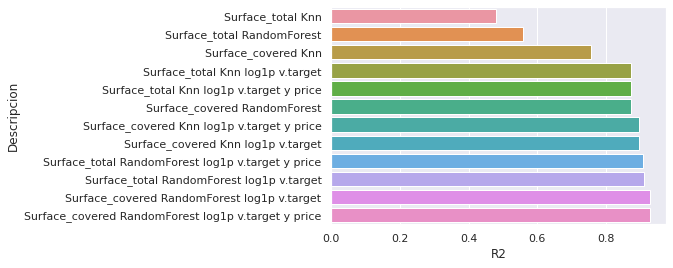

In [ ]:
sns.barplot(x='R2', data=scores.sort_values(by=['R2']), y='Descripcion')
plt.show()

Pasando las variables target a log1p consigue una notable mejora en la reducción del error. Aunque la ganancia de pasar el feature price a log1p es minima, no la vamos a despreciar.
La idea fue en un principio utilizar IterativeImputer pero lamentablemente, por su naturaleza iterative entre los features requiere mucho tiempo de procesamiento, y colab, irónicamente no colabora.

Probaremos utilizando KNN imputer y trataremos de medir su precisión.

######KNN performance

In [ ]:
data[data.surface_covered.isna() | data.surface_total.isna()].property_type.count()*100/data.shape[0]

14.812460267005722

El 14.8% de las instancias tien uno de los valores del feature de superficie perdido.

In [ ]:
data[data.surface_covered.isna() & data.surface_total.isna()].property_type.count()*100/data.shape[0]

13.473735566758823

13.4% de las instanicas tienen ambos valores de superficie perdido.

Cual es la proporcion de pripiedades que tienen valores pedidos para surface_covered tienen tambien valores perdidos para surface_total?

In [ ]:
data[data.surface_covered.isna() & data.surface_total.isna()].property_type.count()*100/data[data.surface_covered.isna() | data.surface_total.isna()].property_type.count()

90.96217187344047

Más del 90% de las instancias tienen uno de estos valores perdidos tienen ambos valores perdidos simultaneamente.

Veamos como es por tipo de propiedad.

In [ ]:
# drop_rate = 0.15
# drop_index = np.random.choice(data.index,5, replace=False)
# drop_index
missings_rate=pd.DataFrame(data[data.surface_covered.isna() & data.surface_total.isna()].groupby('property_type').property_type.count()/data.groupby('property_type').property_type.count())
missings_rate['rate']=missings_rate['property_type']
missings_rate['property_type']=missings_rate.index
missings_rate.reset_index(drop=True,inplace=True)
missings_rate.dropna(inplace=True)
missings_rate

property_type      rate
0           Casa  0.231695
1  Casa de campo  0.208904
3   Departamento  0.127341
4           Lote  0.470882
5        Oficina  0.402985
6             PH  0.004750

Para evaluar que tan efetivo es la imputacion con KNN procederemos asi.

- seleccionaremos un subset con aquellas instancias sin valores nan.
- por cada tipo de propiedad simularemos nan respetando los porcentajes de la tabla anterior.
- imputaremos con KNNimputer
- comaraemos el error de lo imputado con la original. 

In [ ]:
data_tmp=data.dropna() # copio el dataframe a un temporal para la experimentación
data_tmp=data_tmp[data_tmp.l2=='Capital Federal'] # subset de pureba
data_tmp.drop(columns=['title','description'],inplace=True)
data_tmp.surface_total=np.log1p(data_tmp.surface_total)
data_tmp.surface_covered=np.log1p(data_tmp.surface_covered)
data_tmp.price=np.log1p(data_tmp.price)
data_tmp1=data_tmp.copy()
cols=['surface_total','surface_covered']
ids=[]
for index, row in missings_rate.iterrows():
  mask=(data_tmp.property_type==row.property_type)
  id=data_tmp[mask].sample(frac=row.rate, random_state=42).index
  data_tmp.loc[id,['surface_covered','surface_total']]=np.nan
  ids.extend(id)
display(pd.DataFrame(data_tmp.isna().sum()))
data_tmp=pd.get_dummies(data_tmp)

0
lat                 0
lon                 0
l2                  0
l3                  0
rooms               0
bedrooms            0
bathrooms           0
surface_total    8787
surface_covered  8787
price               0
property_type       0

In [ ]:
%%time
scaler=RobustScaler()
scaler.fit(data_tmp)
data_tmp=pd.DataFrame(scaler.transform(data_tmp),index=data_tmp.index,columns=data_tmp.columns)
data_tmp2=KNNImputer(add_indicator=True).fit_transform(data_tmp)

CPU times: user 4min 15s, sys: 2.83 s, total: 4min 17s
Wall time: 4min 6s


Error de la prediccion (solo para las celdas imputadas)

surface_total R2: 0.8859831201497914
surface_covered R2: 0.910808703421491
surface_total RMSE en M2: 33.17626099880165
surface_covered RMSE en M2: 19.773794277747374


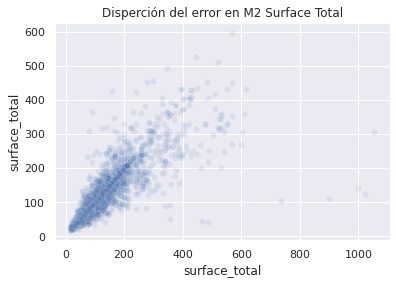

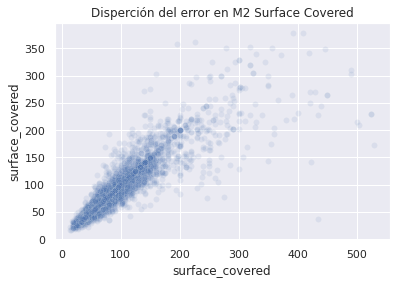

In [ ]:
# print(data_tmp2[:,:-2].shape)
data_tmp3=scaler.inverse_transform(data_tmp2[:,:-2])
data_tmp3=pd.DataFrame(data_tmp3,index=data_tmp.index,columns=data_tmp.columns)
data_tmp3.loc[ids]
print('Error de la prediccion (solo para las celdas imputadas)\n')
# print(r2_score(data_tmp1.surface_total,data_tmp3.surface_total))
print('surface_total R2:',r2_score(data_tmp1.loc[ids].surface_total,data_tmp3.loc[ids].surface_total))
# print(r2_score(data_tmp1.surface_covered,data_tmp3.surface_covered))
print('surface_covered R2:',r2_score(data_tmp1.loc[ids].surface_covered,data_tmp3.loc[ids].surface_covered))
print(
  'surface_total RMSE en M2:',
  mean_squared_error(
    np.exp(data_tmp1.loc[ids].surface_total) -1,
    np.exp(data_tmp3.loc[ids].surface_total) -1,
    squared=False
  )
)

print(
  'surface_covered RMSE en M2:',
  mean_squared_error(
    np.exp(data_tmp1.loc[ids].surface_covered) -1,
    np.exp(data_tmp3.loc[ids].surface_covered) -1,
    squared=False
  )
)
# print(mean_squared_error(np.exp(data_tmp1.surface_total) - 1,np.exp(data_tmp3[5]) - 1, squared=False))

# print(mean_squared_error(np.exp(data_tmp1.surface_covered) -1 ,np.exp(data_tmp3[6])-1 , squared=False))
char = sns.scatterplot(x=np.exp(data_tmp1.loc[ids].surface_total) -1,y=np.exp(data_tmp3.loc[ids].surface_total) -1, alpha=0.1)
char.set_title('Disperción del error en M2 Surface Total')
plt.show()
char = sns.scatterplot(x=np.exp(data_tmp1.loc[ids].surface_covered) -1,y=np.exp(data_tmp3.loc[ids].surface_covered) -1, alpha=0.1)
char.set_title('Disperción del error en M2 Surface Covered')
plt.show()

Bueno, lo que podemos esperar del KNNImputer es una precisión cercana al 90% según el score R2.

Vamos a imputar por el método de KNNimputer, dado que resultó inviable utilizar iterativeimputer con RandomForestRegressor como estimator, dado el tiempo que este consumiría.



##### Imputación por KNN

In [ ]:
%time
mask_surface_covered_wnan=data.surface_covered.isna();
mask_surface_total_wnan=data.surface_total.isna();
data_tmp=None
data_tmp=data.copy()
data_tmp.drop(columns=['title','description'],inplace=True)
data_tmp.surface_total=np.log1p(data_tmp.surface_total)
data_tmp.surface_covered=np.log1p(data_tmp.surface_covered)
data_tmp.price=np.log1p(data_tmp.price)
data_tmp=pd.get_dummies(data_tmp)
scaler.fit(data_tmp)
columns=data_tmp.columns
indexes=data_tmp.index
data_tmp=scaler.transform(data_tmp)
data_tmp.shape
imputer=KNNImputer()
imputer.fit(data_tmp)

CPU times: user 2 µs, sys: 1 µs, total: 3 µs
Wall time: 5.01 µs


KNNImputer(add_indicator=False, copy=True, metric='nan_euclidean',
           missing_values=nan, n_neighbors=5, weights='uniform')

In [ ]:
%time
# variable de archivo file_ds_post_knn
# Imputo por KNN solo si no existe el dataset salvado con los valores imputados
if os.path.isfile(file_ds_post_knn):
  print ("Cargo dataset cache")
  data=pd.read_csv(file_ds_post_knn,index_col=[0])
else:
    print ("Entreno y salvo en cache")
    data_tmp=imputer.transform(data_tmp)
    data_tmp=scaler.inverse_transform(data_tmp)
    data_tmp=pd.DataFrame(data_tmp, columns=columns,index=indexes)
    data_tmp.surface_covered=np.exp(data_tmp.surface_covered) - 1
    data_tmp.surface_total=np.exp(data_tmp.surface_total) - 1
    data['surface_total'].fillna(data_tmp.surface_total,inplace=True)
    data['surface_covered'].fillna(data_tmp.surface_covered,inplace=True)
    data.to_csv(file_ds_post_knn)
    data_tmp

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 5.25 µs
Cargo dataset cache


Verificamos que ya no tenemos nan en nuestro dataset

In [ ]:
data.isna().sum()

lat                0
lon                0
l2                 0
l3                 0
rooms              0
bedrooms           0
bathrooms          0
surface_total      0
surface_covered    0
price              0
title              0
description        0
property_type      0
dtype: int64

Redondeamos los decimales de las celdas imputadas (son las unicas no enteras)

In [ ]:
print(data[~np.equal(np.mod(data.surface_total, 1), 0)].surface_total.count())
data.surface_total=data.surface_total.round(decimals=0)
print(data[~np.equal(np.mod(data.surface_covered, 1), 0)].surface_covered.count())
data.surface_covered=data.surface_covered.round(decimals=0)

18517
19381


In [ ]:
print('surface_covered > surface_totaldata',data[(data.surface_covered > data.surface_total)].rooms.count())
data=data[~(data.surface_covered > data.surface_total)]

surface_covered > surface_totaldata 301


### Genero variables

##### Perks

El campo descripción y titulo contiene algunas palabras claves que podmos explorar y convertir en variables categóricas

In [ ]:
pd.set_option('display.max_colwidth', None)
data[data.description.str.contains('cerramiento', case=False)].description.count()


4015

In [ ]:
perk_list = []
perks={
    'aesrtenar': '\s+a\s+estrenar',
    'moderno': ' moderno ',
    'decategoria': '\s+de\s+categoria|de\scategoría|\s+lujo',
    'xescalera' : '\s+por\s+escalera|\s+por\s+escaléra ',
    'conjardin': '\s+jardin\s+propio|\s+jardín\s+propio' ,
    'cochera': '\s+c/cochera\s+|estacionamiento\s+corte|estacionamiento\s+cubiert|estacionamiento\s+priv|estacionamiento\s+propio|cochera\s+priv|cochera\s+prop|cochera\s+cubiert',
    'baulera': '\s+baulera',
    'gimnasio': 'gimnasio|gym|Gym',
    'lavadero': ' Lavadero| lavadero',
    'viilancia': 'igilancia|eguridad',
    'cancha': 'cancha|Cancha',
    'pileta': 'pileta|picina',
    'sum': ' sum | SUM |menities',
    'boutique': 'boutique',
    'calefaccion' : ' calefacc',
    'AA': ' aire acondicionado | a/acondicionado',
    'sauna' : 'sauna',
    'cerramiento' : '\s+cerramiento'
}

In [ ]:
for perk in perks:
  print(perk, perks[perk])
  data[perk] = np.select(
    condlist=[ # note you could use the case-insensitive search with `case=False`
      data.description.str.contains(perks[perk], case=False), 
      ],
      choicelist=[1], # dummy variables
      default=0 # you could set it to `np.nan` etc
  )
  print(data[data[perk]==1][perk].count())
  perk_list.append(perk)

#   # no vale la pena con este dataset por que lo que encuentra en title ya lo encuentra en description
#   # data[data[perk]==0][perk] = np.select(
#   #   condlist=[ # note you could use the case-insensitive search with `case=False`
#   #     data[data[perk]==0].title.str.contains(perks[perk], case=False),
#   #     ],
#   #     choicelist=[1], # dummy variables
#   #     default=0 # you could set it to `np.nan` etc
#   # )
#   # print(data[data[perk]==1][perk].count())
  

aesrtenar \s+a\s+estrenar
10213
moderno  moderno 
4236
decategoria \s+de\s+categoria|de\scategoría|\s+lujo
9801
xescalera \s+por\s+escalera|\s+por\s+escaléra 
8318
conjardin \s+jardin\s+propio|\s+jardín\s+propio
573
cochera \s+c/cochera\s+|estacionamiento\s+corte|estacionamiento\s+cubiert|estacionamiento\s+priv|estacionamiento\s+propio|cochera\s+priv|cochera\s+prop|cochera\s+cubiert
7828
baulera \s+baulera
16656
gimnasio gimnasio|gym|Gym
12940
lavadero  Lavadero| lavadero
43957
viilancia igilancia|eguridad
20294
cancha cancha|Cancha
4041
pileta pileta|picina
18898
sum  sum | SUM |menities
19402
boutique boutique
240
calefaccion  calefacc
16162
AA  aire acondicionado | a/acondicionado
10415
sauna sauna
5292
cerramiento \s+cerramiento
3699


In [ ]:
# pd.set_option('display.max_colwidth', None)
# pd.set_option("display.max_rows", None)
# data[data.description.str.contains('hidro')].description.count()
# # display(pd.DataFrame(data[data.description.str.contains('calefacc')].description.count()

# # ppt_master.head(1000).description

### Dropeo columnas title, descripción


In [ ]:
data.drop(columns=['title','description'], inplace=True)

### Me quedo con Capital Federal, PH, Departamentos y Casas

Para poder comparar este modelo con el del proyecto anterior y para ser mas veloz en los entrenamientos.

In [ ]:
data=data[
          (data.l2=='Capital Federal') &
          (data.property_type.isin(['Casa','PH','Departamento']))
]

### SALVO DATASET SIN PCA Y SIN ESCALAR

In [ ]:
file_ds_almos_ready_wo_pca
if os.path.isfile(file_ds_almos_ready_wo_pca):
  print ("Cargo dataset cache")
  data=pd.read_csv(file_ds_almos_ready_wo_pca,index_col=[0])
else:
  print('Salvo en cache')
  data.to_csv(file_ds_almos_ready_wo_pca)

Cargo dataset cache


###2. Encoding

#### Encoding simple

Simplemente genero las variables dummies data1

In [ ]:
property_type=data[['property_type']]
l2=data[['l2']]
l3=data[['l3']]
data1=pd.get_dummies(data,drop_first=True)

#### Grid por lat lon

Genero una grilla por lat y lon 

Este dataset no se utilizará para la predicción de precios, solo para analisis y quiza para clustering.

In [ ]:
data3=data.copy()
step = 0.003 # redondeo a 2 decimales que son aproximadamente 100mx100m, como lo divido 3 es de aprox 300x300m
to_bin = lambda x: np.floor(x / step) * step
data3["latbin"] = data3.lat.map(to_bin)
data3["lonbin"] = data3.lon.map(to_bin)
# data3.drop(['lat','lon'], inplace=True, axis=1)

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


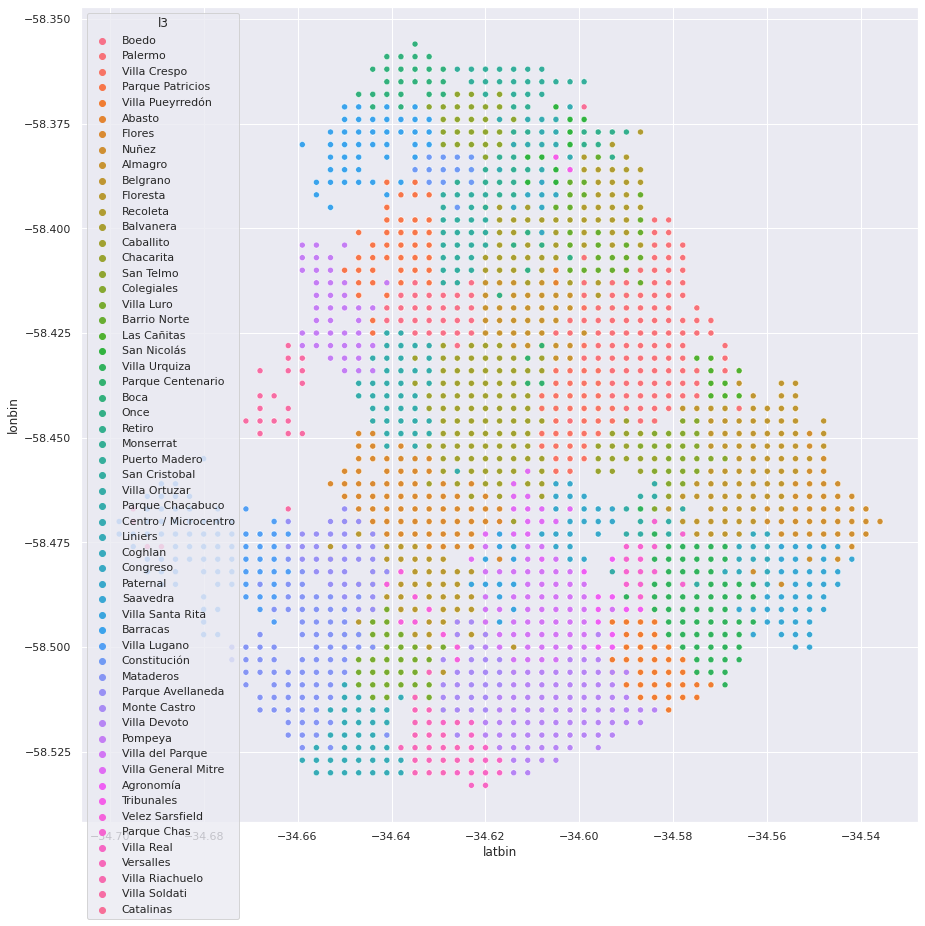

In [ ]:
plt.figure(figsize=(15,15))
sns.scatterplot(data3.latbin,data3.lonbin,hue='l3',data=data)
plt.show()

Genero un nuevo feature l3_m2_price, esta columna es el valor de la media del cuadrante de la grilla.

In [ ]:
# Averiguel el precio del metro cuadrado de cada propiedad
# price_m2 debe ser eliminada!!!! lo hago mas adelante
data3['price_m2']=(data3.price/data3.surface_total).astype(int)

In [ ]:
# Genero l3_m2_price, contiene la media del valor del m2 de ese cuadrante
data3['l3_m2_price']=data3.groupby(by=['latbin','lonbin']).price_m2.transform('mean').astype(int)
data3.drop(['price_m2'], axis=1,inplace=True)

In [ ]:
data3.drop(columns=['latbin','lonbin','bedrooms'],inplace=True)

In [ ]:
data3=pd.get_dummies(data3, drop_first=True)

###4. Escalado de datos

El escalado de datos se realizará al momento de entrenar los modelos. Elegimos RobsutScaler por que en teoría es más resistente a valores atípico al mismo tiempo que mantiene la relación de los valores entre los demás features.
Si bien intentamos deshacernos de ellos en etapas anteriores, con este scaler intentamos minimizar el impacto de los valores atípicos remanentes.

In [ ]:
# surface_total_1=data1[data1.property_type_PH==1][['surface_total']]
# # surface_total_log = np.log1p(data1[['surface_total']])
# sns.boxplot(np.log1p(data1.surface_total ), palette=palette)
# plt.show()
# tmp=scaler.fit_transform(pd.DataFrame(np.log1p(data1.surface_total )))
# chart = sns.boxplot(tmp)
# chart.set_xticklabels('asdas')
# plt.show()
# tmp=MinMaxScaler().fit_transform(pd.DataFrame(np.log1p(data1.surface_total )))
# sns.boxplot(tmp)
# plt.show()
# tmp=StandardScaler().fit_transform(pd.DataFrame(np.log1p(data1.surface_total )))
# sns.boxplot(tmp)
# plt.show()

# scaler


###5. Generación de nuevas variables predictoras/reducción de dimensionalidad (SVD/PCA)

Para reduccion de dimensionalida usaremos PCA, la vamos a aplicar antes de utilizar antes de ingresar el datafrem a los modelos. Utilizaremos PCA con el iperparametro 0.95 que retiene el 95% de la informacion reduciendo el mumero de features a cerca de la mitad.

In [ ]:
display(data1.drop(['price'],axis=1).shape)

(83711, 83)

Shape previo al PCA 83 columnas

In [ ]:
display(
    PCA(.95).fit_transform(
        scaler.fit_transform(data1.drop(['price'],axis=1))
        ).shape
    )

(83711, 30)

Shape post PCA 30 columnas

### Correlaciones

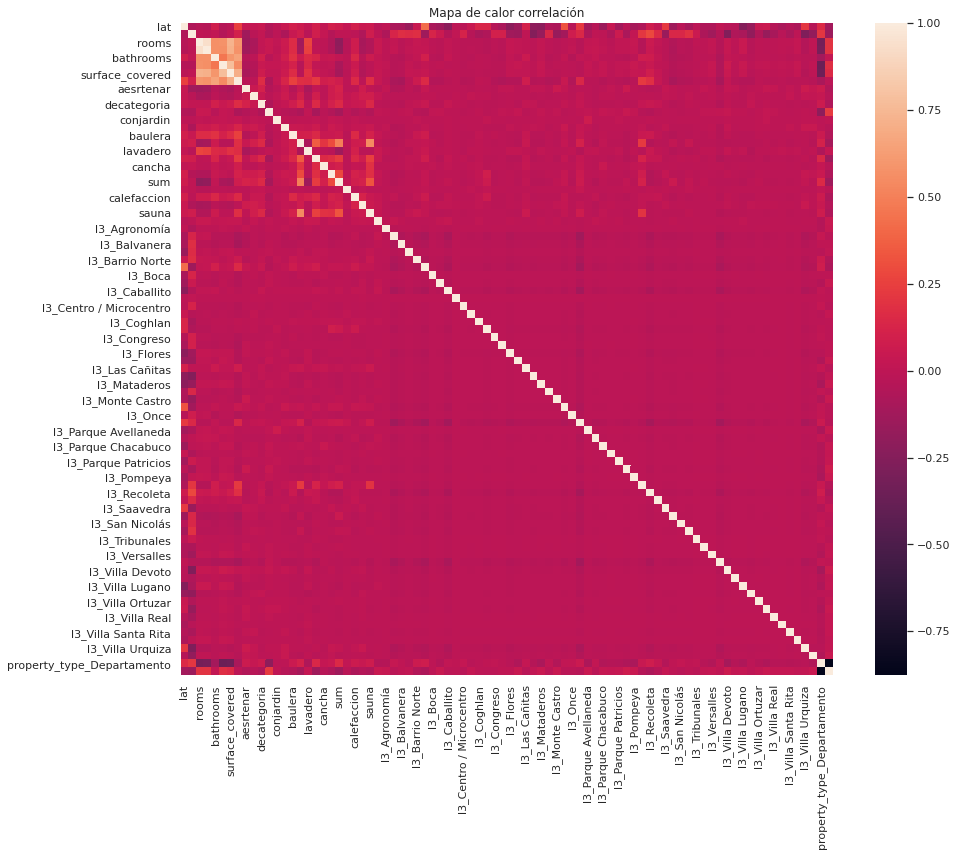

In [ ]:
corrmat = data1.corr()
f, ax = plt.subplots(figsize=(15, 12))
chart= sns.heatmap(corrmat,  square=True);
chart.set_title('Mapa de calor correlación')
plt.show()

Se ve un cuadrado mas 'claro' arriba a la izquierda, esto denota multicolinearidad, veamos si PCA la elimina.


In [ ]:
data_tmp=scaler.fit_transform(data1.drop(columns=['price']))
data_tmp=pd.DataFrame(PCA(.95).fit_transform(data_tmp), index=data1.index)
# data_tmp=pd.DataFrame(data_tmp, index=data1.index).join(data1.price)
data_tmp['price']=data1.price

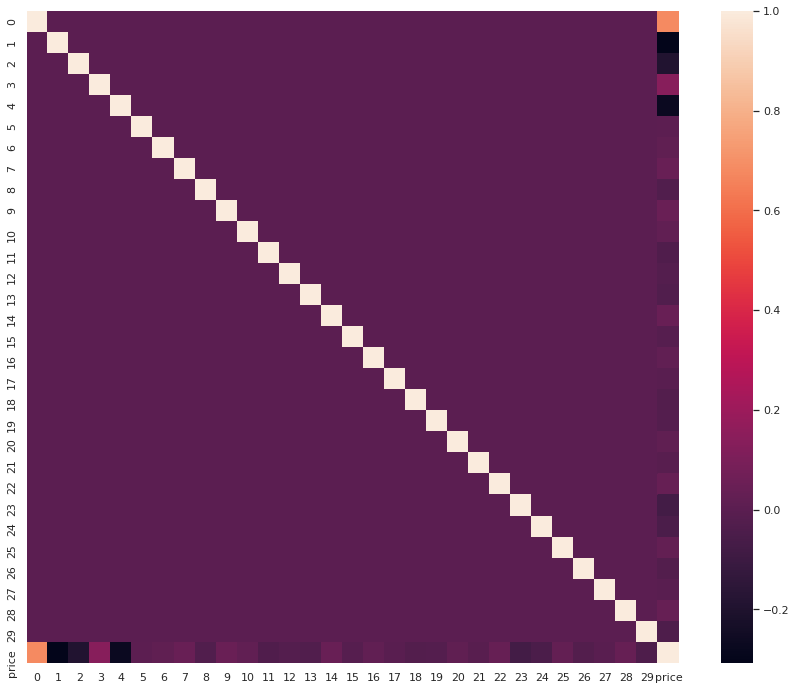

In [ ]:
corrmat = data_tmp.corr()
f, ax = plt.subplots(figsize=(15, 12))
sns.heatmap(corrmat,  square=True, );

In [ ]:
corrmat

0             1  ...            29     price
0      1.000000e+00  2.805807e-17  ...  1.078095e-16  0.682068
1      2.805807e-17  1.000000e+00  ... -2.838349e-17 -0.308338
2     -3.482824e-16 -2.170730e-17  ... -1.253109e-16 -0.193137
3      1.266482e-16 -1.811518e-16  ...  4.977177e-17  0.137692
4      2.461078e-16  2.241620e-16  ...  9.223398e-17 -0.268670
5      6.009726e-16  5.629248e-17  ...  2.343353e-16  0.004255
6      2.428335e-16  1.398156e-17  ...  7.705275e-17  0.017206
7     -2.416737e-16  4.768070e-17  ... -9.863927e-17  0.043328
8      8.814420e-17  9.106936e-18  ...  2.146913e-17 -0.032340
9     -3.829997e-16  4.123896e-16  ... -9.795125e-17  0.048557
10    -9.210694e-17 -1.510367e-17  ...  1.968117e-17  0.023404
11    -4.376277e-17  8.857525e-18  ...  2.523467e-17 -0.033165
12    -5.656854e-17 -2.134703e-17  ... -5.513957e-17 -0.018076
13     9.993446e-18  1.257072e-17  ...  1.145319e-16 -0.031525
14     7.842789e-17  6.082644e-17  ... -3.800537e-17  0.044045
15    -9.692970e-18  9.848012e-18  ...  3.592461e-16 -0.012991
16     5.478537e-17 -5.358716e-17  ... -2.403573e-17  0.022447
17    -4.366063e-17  1.562306e-17  ...  1.807261e-16 -0.002317
18    -1.534849e-17  5.898832e-17  ... -6.784260e-17 -0.025904
19    -3.039836e-17 -1.034475e-16  ... -8.835090e-17 -0.019058
20    -7.432596e-17 -9.919735e-17  ... -3.201107e-16  0.014272
21     2.027285e-17  5.295085e-17  ... -6.692990e-17 -0.008643
22    -2.775846e-17  1.402813e-17  ... -2.906273e-16  0.037869
23     1.032091e-16 -4.711169e-17  ...  1.387151e-16 -0.076883
24     1.477204e-17 -4.206669e-17  ...  2.695393e-17 -0.048009
25     4.252321e-18  3.382961e-17  ...  2.270915e-16  0.024566
26     1.881568e-17  5.185066e-17  ... -2.964245e-16 -0.026772
27    -9.360038e-17  2.837373e-17  ... -1.019604e-16 -0.006129
28    -4.493734e-17  5.736374e-17  ...  1.009260e-16  0.034746
29     1.078095e-16 -2.838349e-17  ...  1.000000e+00 -0.039498
price  6.820677e-01 -3.083377e-01  ... -3.949785e-02  1.000000

[31 rows x 31 columns]

Se puede ver en el mapa de calor que la multicolinearidad desaparece. La correlación de entre variables no target son cercanas a 0.

Veamos igual la correlacion entre los features y price

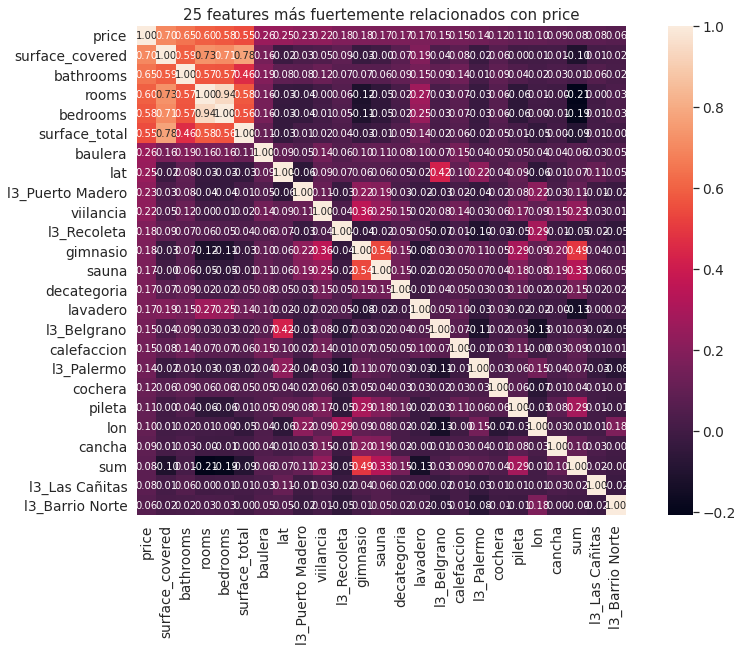

In [ ]:
k = 25 #number of variables for heatmap

corrmat = data1.corr()
feat='price'
cols = corrmat.nlargest(k, feat)[feat].index
cm = np.corrcoef(data1[cols].values.T)
sns.set(font_scale=1.25)
# f, ax = plt.subplots(figsize=(9, 15))
plt.figure(figsize=(15,9))
chart = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
chart.set_title(str(k)+ ' features más fuertemente relacionados con ' + feat)
plt.show()

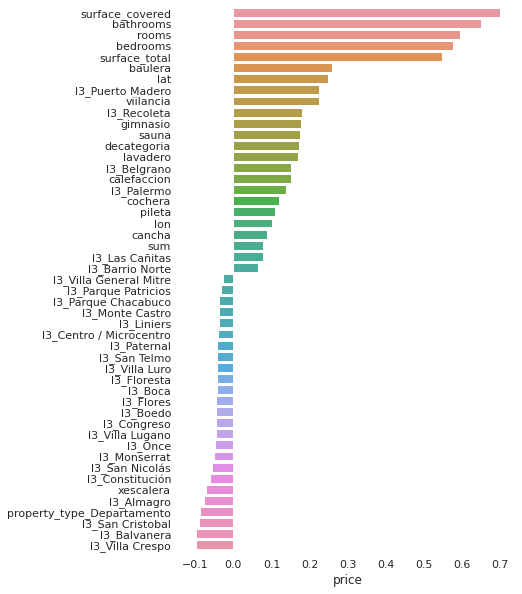

In [ ]:
feat_corr=corrmat['price'].sort_values(ascending=False)[:25].append(
  corrmat['price'].sort_values(
      ascending=True)[:25]
      ).sort_values(ascending=False)[1:]
sns.set(style='white', rc={"axes.facecolor": (0, 0, 0, 0)})
plt.figure(figsize=(6,10))
# plt.axhline(lw=3)

sns.barplot(x=feat_corr,y=feat_corr.index)
sns.despine(bottom=True, left=True)
plt.show()

Interesante que algunos de los features que creamos estan correalcionados con el precio.

### Vuelve a entrenar el modelo implementado en la Entrega 01
 - en particular, el árbol de decisión - y evalúa su desempeño a partir del dataset obtenido luego de transformar los datos. ¿Hay una mejora en su desempeño? Sea cual sea la respuesta, intenta explicar a qué se debe.

##### Ejecuciones

Vamos a probar algunas ejecuciones de treeregressor. 

Vamos a probar entrenar el dataset preprocesando los datos en distinto orden y permutaciones.

Las opciones son:

* Escalado de datos seguido de train_test_split.
* train_test_split seguide del escalado de datos.
* PCA seguido del train_test_split.
* PCA + escalado de datos seguido de train_test_split.
* PCA + train_test_split seguide del escalado de datos.

Tambien vamos a probar aplocando np.log a la variable target.

In [ ]:
max_nei=np.arange(10,30)

###
benchscores=pd.DataFrame() ### resultados de los entrenamientos

In [ ]:
entrega01 = pd.DataFrame()
def addeva(descr=None, rmse=None):
  return pd.DataFrame({'Modelo':[descr],'Resultado':[rmse]})

Setemos una máscar para quedarnos con los mismos tipos de filas que utilizamos en el primer proyecto.
l2 = Capital Federal
property_type igual a Departamento, PH y Casa

###### Entrega 1 RF Splite antes del escalado

10  11  12  13  14  15  16  17  18  19  20  21  22  23  24  25  26  27  28  29  RMSE:  44057 Mejor Profundidad/Nuro de Vecinos:  21


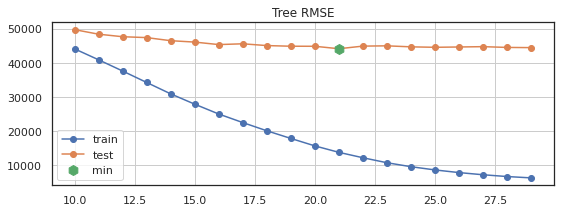

Modelo: tree RMSE: 44057.6156404303 Mejor Profundidad/Nuro de Vecinos: 21

CPU times: user 13.2 s, sys: 23.9 ms, total: 13.2 s
Wall time: 13.2 s


In [ ]:
%%time
sns.set_style('white', {'legend.frameon':True})
X_train, X_test, y_train, y_test =escal_split_before(data1)
mytree()
# entrega01=entrega01.append(addeva('E1 RF Splite antes del escalado',myeval()), ignore_index=True)
tmp=pd.DataFrame({
    'Modelo':['E1 RF Splite antes del escalado'],
    'Score R2 (mean)':[np.nan],
    'RMSE (mean)':[int(myeval())],
    'Tiempo de entrenamiento (segundos)':[np.nan],
    'crossvalrslts': [np.nan]
    })
benchscores=benchscores.append(tmp, ignore_index=True)

###### Enrtega 1 RF Splite despues del escalado

10  11  12  13  14  15  16  17  18  19  20  21  22  23  24  25  26  27  28  29  RMSE:  44227 Mejor Profundidad/Nuro de Vecinos:  23


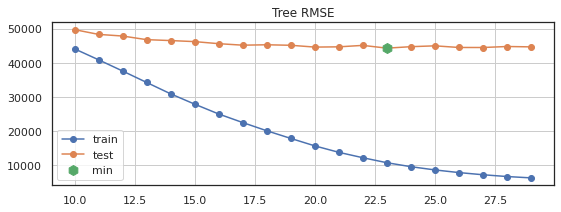

Modelo: tree RMSE: 44227.11566219138 Mejor Profundidad/Nuro de Vecinos: 23

CPU times: user 13.5 s, sys: 30.8 ms, total: 13.5 s
Wall time: 13.5 s


In [ ]:
%%time
X_train, X_test, y_train, y_test =escal_split_after(data1)
mytree()
tmp=pd.DataFrame({
    'Modelo':['E1 RF Splite despues del escalado'],
    'Score R2 (mean)':[np.nan],
    'RMSE (mean)':[int(myeval())],
    'Tiempo de entrenamiento (segundos)':[np.nan],
    'crossvalrslts': [np.nan]
    })
benchscores=benchscores.append(tmp, ignore_index=True)

###### Entrega 1 PCA previo a escalado 

10  11  12  13  14  15  16  17  18  19  20  21  22  23  24  25  26  27  28  29  RMSE:  68218 Mejor Profundidad/Nuro de Vecinos:  26


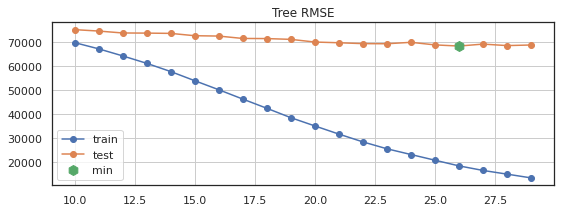

Modelo: tree RMSE: 68218.20817177069 Mejor Profundidad/Nuro de Vecinos: 26



In [ ]:
pca = PCA(.95)
pca.fit(data1.drop(columns=['price']))
X_train, X_test, y_train, y_test = train_test_split(pca.transform(data1.drop(columns=['price'])),data1.price)

mytree()
tmp=pd.DataFrame({
    'Modelo':['E1 PCA previo a escalado'],
    'Score R2 (mean)':[np.nan],
    'RMSE (mean)':[int(myeval())],
    'Tiempo de entrenamiento (segundos)':[np.nan],
    'crossvalrslts': [np.nan]
    })
benchscores=benchscores.append(tmp, ignore_index=True)

In [ ]:
X_train.shape

(62783, 2)

Ejecutar PCA sin escalar previamente nos deja solo con 2 features.

###### Entrega 1 split antes del escalado+PCA

10  11  12  13  14  15  16  17  18  19  20  21  22  23  24  25  26  27  28  29  RMSE:  49327 Mejor Profundidad/Nuro de Vecinos:  16


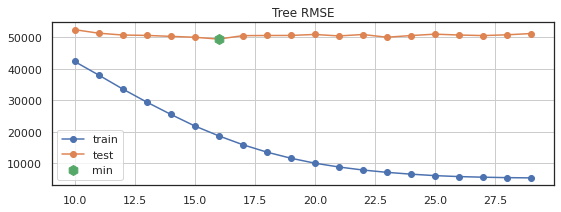

Modelo: tree RMSE: 49327.42301094133 Mejor Profundidad/Nuro de Vecinos: 16

CPU times: user 50.5 s, sys: 195 ms, total: 50.7 s
Wall time: 50.1 s


In [ ]:
%%time
X_train, X_test, y_train, y_test =escal_split_before(data1)
pca = PCA(.95)
pca.fit(X_train)
X_train = pca.transform(X_train)
X_test = pca.transform(X_test)
mytree()
tmp=pd.DataFrame({
    'Modelo':['E1 split antes del escalado+PCA'],
    'Score R2 (mean)':[np.nan],
    'RMSE (mean)':[int(myeval())],
    'Tiempo de entrenamiento (segundos)':[np.nan],
    'crossvalrslts': [np.nan]
    })
benchscores=benchscores.append(tmp, ignore_index=True)

In [ ]:
X_train.shape

(58597, 30)

###### Entrega 1 split despues del escalado+PCA

10  11  12  13  14  15  16  17  18  19  20  21  22  23  24  25  26  27  28  29  RMSE:  49444 Mejor Profundidad/Nuro de Vecinos:  13


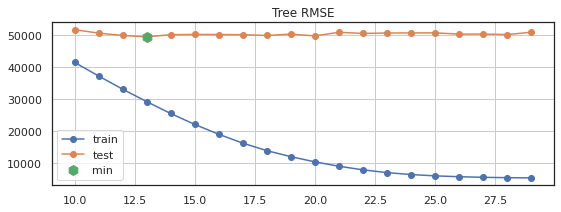

Modelo: tree RMSE: 49444.87393485398 Mejor Profundidad/Nuro de Vecinos: 13



In [ ]:
X_train, X_test, y_train, y_test =escal_split_after(data1)
pca = PCA(.95)
pca.fit(X_train)
X_train = pca.transform(X_train)
X_test = pca.transform(X_test)
mytree()
tmp=pd.DataFrame({
    'Modelo':['E1 split despues del escalado+PCA'],
    'Score R2 (mean)':[np.nan],
    'RMSE (mean)':[int(myeval())],
    'Tiempo de entrenamiento (segundos)':[np.nan],
    'crossvalrslts': [np.nan]
    })
benchscores=benchscores.append(tmp, ignore_index=True)

In [ ]:
X_train.shape

(58597, 30)

###### Entrega 1 split despues del escalado+PCA+log(y)

10  sq mean_squared_error: 44253.375207368095
y_true.shape: (58597,)
y_pred.shape: (58597, 1)
sq mean_squared_error: 52167.681397983906
y_true.shape: (25114,)
y_pred.shape: (25114, 1)
11  sq mean_squared_error: 39700.847715764656
y_true.shape: (58597,)
y_pred.shape: (58597, 1)
sq mean_squared_error: 51015.42655669663
y_true.shape: (25114,)
y_pred.shape: (25114, 1)
12  sq mean_squared_error: 35261.86125505735
y_true.shape: (58597,)
y_pred.shape: (58597, 1)
sq mean_squared_error: 50276.10327393055
y_true.shape: (25114,)
y_pred.shape: (25114, 1)
13  sq mean_squared_error: 30792.63387696093
y_true.shape: (58597,)
y_pred.shape: (58597, 1)
sq mean_squared_error: 49966.31661672154
y_true.shape: (25114,)
y_pred.shape: (25114, 1)
14  sq mean_squared_error: 26849.385333622726
y_true.shape: (58597,)
y_pred.shape: (58597, 1)
sq mean_squared_error: 49686.615926426435
y_true.shape: (25114,)
y_pred.shape: (25114, 1)
15  sq mean_squared_error: 23317.57148239598
y_true.shape: (58597,)
y_pred.shape: (58

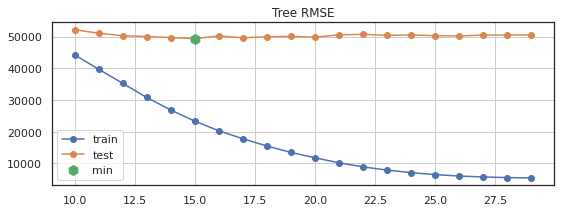

Modelo: tree RMSE: 49306.04533567431 Mejor Profundidad/Nuro de Vecinos: 15



In [ ]:
data1.price=np.log(data1.price)
# data1.surface_covered=np.log(data1.surface_covered)
# data1.surface_total=np.log(data1.surface_total)
X_train, X_test, y_train, y_test =escal_split_after(data1)
data1.price=np.exp(data1.price)
# data1.surface_covered=np.exp(data1.surface_covered)
# data1.surface_total=np.exp(data1.surface_total)
pca = PCA(.95)
pca.fit(X_train)
X_train = pca.transform(X_train)
X_test = pca.transform(X_test)
mytree(exp_mean_squared_error)
tmp=pd.DataFrame({
    'Modelo':['E1 split despues del escalado+PCA+log(y)'],
    'Score R2 (mean)':[np.nan],
    'RMSE (mean)':[int(myeval())],
    'Tiempo de entrenamiento (segundos)':[np.nan],
    'crossvalrslts': [np.nan]
    })
benchscores=benchscores.append(tmp, ignore_index=True)

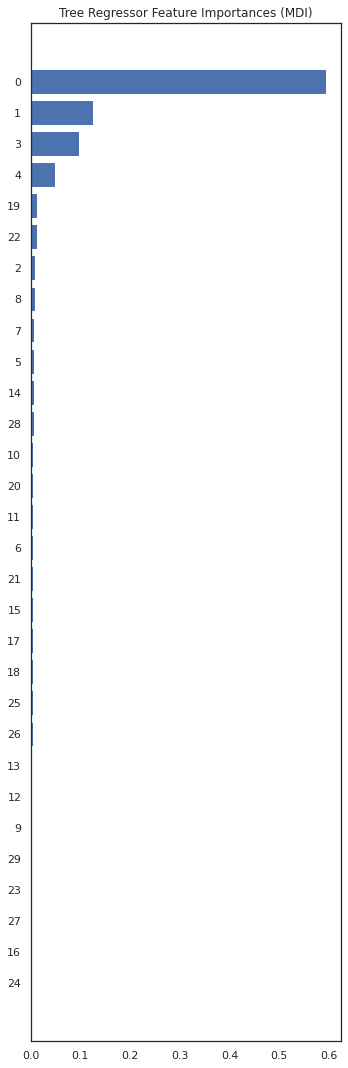

In [ ]:
X_train, X_test, y_train, y_test =escal_split_after(data1)
pca = PCA(.95)
pca.fit(X_train)
X_train = pd.DataFrame(pca.transform(X_train))
X_test = pca.transform(X_test)
tree01=DecisionTreeRegressor(max_depth=15).fit(X_train, y_train)
plot_fi(tree01.feature_importances_,X_train.columns)
X_train, X_test, y_train, y_test =escal_split_after(data1)
tree02=DecisionTreeRegressor(max_depth=15).fit(X_train, y_train)

###### feature_importances_ (SIN PCA)

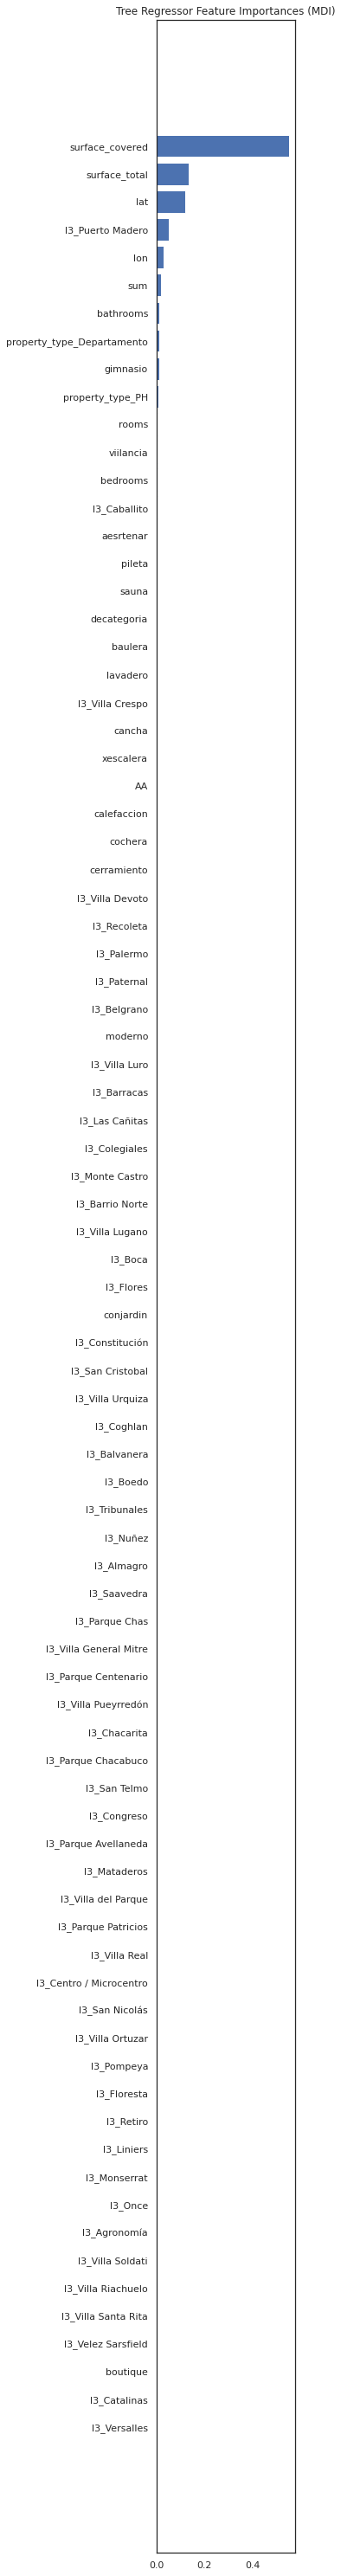

In [ ]:
# plt.figure(figsize=(30,40))
plot_fi(
    tree02.feature_importances_,
    X_train.columns)

###### Resultados

Modelo  RMSE (mean)
0           E1 RF Splite antes del escalado        44057
1         E1 RF Splite despues del escalado        44227
2                  E1 PCA previo a escalado        68218
3           E1 split antes del escalado+PCA        49327
4         E1 split despues del escalado+PCA        49444
5  E1 split despues del escalado+PCA+log(y)        49306

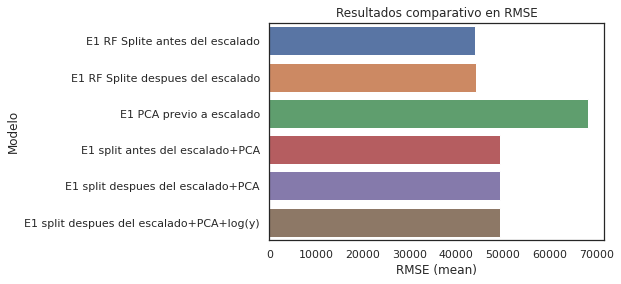

In [ ]:
# entrega01.Resultado=entrega01.Resultado.astype(int)
display(benchscores[['Modelo','RMSE (mean)']])
chart = sns.barplot(x='RMSE (mean)',y='Modelo',data=benchscores)
chart.set_title('Resultados comparativo en RMSE')
plt.show()

Conclusiones:

Primero traigo al recuerdo el mejor resultado obtenudo en proyecto 1

***Modelo: tree RMSE: 146562 Mejor Profundidad/Nro de Vecinos: 15***

Comparados con ese modelo re entrenado con el nuevo dataset:

* 1 Todos los modelos dieron mejores resultado que en el proyecto anterior.

* 2 Sin PCA, para este modelo, este dataset se comporta mejor que con PCA
* 3 Aplicarle log1p a la variable no mejora de forma considerable el desempeño del modelo.
* 4 PCA al 95% reduce la dimencion de 84 a 30 features.

* 5 El escalado antes o despues del split afecta de forma muy leve el resultado.

Con o sin PCA las primeas 4 o 5 features más importantes son las que mas valor aportan, sin embargo en el modelo sin PCA la reducción de impureza parece ir casi a 0 mucho mas 'rapido' que con PCA, que pareciera repartir esa ganancia entre mas features. Puede ser un tema de escala de gráfico. 



##PARTE B - Modelos Avanzados

### 6. Elige dos de los modelos avanzados 
Elige dos de los modelos avanzados vistos (en el caso de regresión, considera una regresión lineal con atributos polinómicos y regularización). Entrénalos y evalúalos con sus argumentos por defecto. No te olvides de hacer un train/test split y usar Validación Cruzada.



#### Funciones

#### Inicio Variables

In [ ]:
# benchscores=pd.DataFrame()
data1.price=np.log1p(data1.price)
data1.surface_covered=np.log1p(data1.surface_covered)
data1.surface_total=np.log1p(data1.surface_total)
X_train, X_test, y_train, y_test =escal_split_after(data1)
# X_train, X_test, y_train, y_test =escal_split_after(data1.drop([*perks],axis=1))
data1.price=np.exp(data1.price) - 1 
data1.surface_covered=np.exp(data1.surface_covered) - 1
data1.surface_total=np.exp(data1.surface_total) - 1
pca = PCA(.95)
pca.fit(X_train)
X_train = pca.transform(X_train)
X_test = pca.transform(X_test)
X=np.r_[X_train,X_test]
y=np.r_[y_train,y_test]

#### RandomForest + validación cruzada

Inicialización del regresor y ejecución de la validación cruzada

In [ ]:
%%time
rgs_rf = RandomForestRegressor(n_jobs=-1, random_state=42)
tree_scores = cross_validate(
    rgs_rf, 
    X,
    y,
    cv=CV, verbose=VERBOSE,   scoring=scorers,return_estimator=True)

[CV]  ................................................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


sq mean_squared_error: 37966.97569009235
y_true.shape: (27904,)
y_pred.shape: (27904,)
[CV] ..... , myscorer=-37966.976, nmse=-0.023, r2=0.925, total= 2.3min
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  2.3min remaining:    0.0s


sq mean_squared_error: 37706.85219147355
y_true.shape: (27904,)
y_pred.shape: (27904,)
[CV] ..... , myscorer=-37706.852, nmse=-0.023, r2=0.925, total= 2.3min
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  4.6min remaining:    0.0s


sq mean_squared_error: 38472.22898198991
y_true.shape: (27903,)
y_pred.shape: (27903,)
[CV] ..... , myscorer=-38472.229, nmse=-0.023, r2=0.925, total= 2.3min
CPU times: user 5.13 s, sys: 718 ms, total: 5.84 s
Wall time: 6min 49s


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  6.8min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  6.8min finished


Almacenamiento de los resultados para el análisis

In [ ]:
tmp=pd.DataFrame({
    'Modelo':['RandomForestRegressor'],
    'Score R2 (mean)':[tree_scores['test_r2'].mean()],
    'RMSE (mean)':[-tree_scores['test_myscorer'].mean()],
    'Tiempo de entrenamiento (segundos)':[tree_scores['fit_time'].mean()],
    'crossvalrslts': [tree_scores]
    })
benchscores=benchscores.append(tmp, ignore_index=True)

In [ ]:

tmp.iloc[:,0:3]

Modelo  Score R2 (mean)   RMSE (mean)
0  RandomForestRegressor         0.924912  38048.685621

#### XGboost + validación cruzada

Inicialización del regresor y ejecución de la validación cruzada

In [ ]:
rgs_xg=XGBRegressor(objective ='reg:squarederror',tree_method = 'gpu_hist', random_state=42)
xgb_scores = cross_validate(
    rgs_xg, 
    X,
    y,
    cv=CV, verbose=VERBOSE,  n_jobs=-1 ,   scoring=scorers,return_estimator=True)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    4.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    4.3s finished


Almacenamiento de los resultados para el análisis

In [ ]:
tmp=pd.DataFrame({
    'Modelo':['XGBRegressor'],
    'Score R2 (mean)':[xgb_scores['test_r2'].mean()],
    'RMSE (mean)':[-xgb_scores['test_myscorer'].mean()],
    'Tiempo de entrenamiento (segundos)':[xgb_scores['fit_time'].mean()],
    'crossvalrslts': [xgb_scores]
    })
benchscores=benchscores.append(tmp, ignore_index=True)

In [ ]:
tmp.iloc[:,0:3]

Modelo  Score R2 (mean)   RMSE (mean)
0  XGBRegressor         0.863577  51688.950316

#### StackingRegressor + validación cruzada

Inicialización del regresor y ejecución de la validación cruzada

In [ ]:
%%time
from sklearn.model_selection import LeaveOneOut
estimators = [
    ('XGBRegressor' , rgs_xg),
    ('RandomForestRegressor' , rgs_rf)
]

stacking_regressor = StackingRegressor(estimators=estimators,
                                       final_estimator=RidgeCV(),verbose=VERBOSE,cv=CV)

CPU times: user 84 µs, sys: 2 µs, total: 86 µs
Wall time: 90.4 µs


In [ ]:
%%time
stack_scores = cross_validate(
    stacking_regressor, 
    X,
    y,
    cv=CV, verbose=VERBOSE,   scoring=scorers,return_estimator=True)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  ................................................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    1.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    1.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.5min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  2.9min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  4.4min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  4.4min finished


sq mean_squared_error: 37682.82794514837
y_true.shape: (27904,)
y_pred.shape: (27904,)
[CV] ..... , myscorer=-37682.828, nmse=-0.023, r2=0.925, total= 6.7min
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  6.7min remaining:    0.0s
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    1.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    1.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.5min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  2.9min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  4.4min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  4.4min finished


sq mean_squared_error: 37390.83303239146
y_true.shape: (27904,)
y_pred.shape: (27904,)
[CV] ..... , myscorer=-37390.833, nmse=-0.023, r2=0.925, total= 6.7min
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed: 13.4min remaining:    0.0s
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    1.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    1.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.5min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  2.9min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  4.4min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  4.4min finished


sq mean_squared_error: 38198.84556151319
y_true.shape: (27903,)
y_pred.shape: (27903,)
[CV] ..... , myscorer=-38198.846, nmse=-0.023, r2=0.925, total= 6.7min
CPU times: user 20.1 s, sys: 4.34 s, total: 24.5 s
Wall time: 20min 1s


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed: 20.0min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed: 20.0min finished


Almacenamiento de los resultados para el análisis

In [ ]:
tmp=pd.DataFrame({
    'Modelo':['StackingRegressor'],
    'Score R2 (mean)':[stack_scores['test_r2'].mean()],
    'RMSE (mean)':[-stack_scores['test_myscorer'].mean()],
    'Tiempo de entrenamiento (segundos)':[stack_scores['fit_time'].mean()],
    'crossvalrslts': [stack_scores]
    })
benchscores=benchscores.append(tmp, ignore_index=True)

In [ ]:
benchscores.iloc[:,:4]

Modelo  ...  Tiempo de entrenamiento (segundos)
0           E1 RF Splite antes del escalado  ...                                 NaN
1         E1 RF Splite despues del escalado  ...                                 NaN
2                  E1 PCA previo a escalado  ...                                 NaN
3           E1 split antes del escalado+PCA  ...                                 NaN
4         E1 split despues del escalado+PCA  ...                                 NaN
5  E1 split despues del escalado+PCA+log(y)  ...                                 NaN
6                     RandomForestRegressor  ...                          135.802613
7                              XGBRegressor  ...                            1.716640
8                         StackingRegressor  ...                          399.922289

[9 rows x 4 columns]

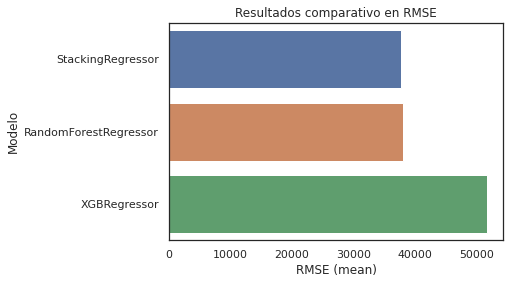

In [ ]:
tmp=benchscores.iloc[6:,:4].sort_values(by=['RMSE (mean)'])
chart = sns.barplot(x='RMSE (mean)',y='Modelo',data=tmp)
chart.set_title('Resultados comparativo en RMSE')
plt.show()

#### Resumen

Durante este benchmark algunos regresores fueron parametrizados, estos hiperparametros eran referente al uso de gpu cuando fuera posible, a la concurrencia de trabajos y random state, y el único objetivo era hacerlos más rápidos y/o para poder reproducir sus resultados.
Las conclusiones sobre cada regresor citado de mejor a peor desempeño respecto al error.

* StackingRegressor: Con este meta regresor utilizamos como pre_estimadores a XGBRegressor y RandomForestRegressor. Con los mismos hiperparametros que los utilizamos cuando los evaluamos por separado, es más,  reutilice las mismas instancias (objetos) que en las evaluaciones individuales de cada uno anteriores. Fue muy interesante que a pesar de que los estimadores utilizados dieron pruebas dispares, con un score R2 de 0.924 uno y 0.863 el otro, el estimador final logró con esta mejorar el resultado, mínimamente pero una mejora al fin, superando de esta manera a los resultados obtenidos por RandomForestRegressor. No voy a avanzar con este modelo por que demora demasiado, pero parece ser  opción cuando se necesita reducir el error.


* RandomForestRegressor: muy, muy cerca del score de StackingRegressor.

* XGBRegressor: fue el peor de los tres,peor incluso que los modelos básicos re entrenados de la "Parte A". Cabe aclarar que los hiperparametros defecto de este estimador es muy conservadores, por ejemplo, max_depth es de 3 (consume mucha memoria y con este dataset no pude llevarlo más allá de los 17 sin hacer crashear el kernel de colab) comparado con RandomForestRegressor que no tiene límite para max_depth.


###7. 
Optimiza sus hiperparámetros mediante Validación Cruzada y Grid Search o Random Search.

La optimización de hiperparametros se realizó de esta manera:

* RandomSearchCV: no se usó GridSearch por un tema de tiempo, seguramente los hiperparametros del best_estimator pueden no ser los realmente mejores. 

* Se usó la variante CV: Existen dos variantes, RandomSearch y RandomSearchCV, se utilizó esta última porque incorpora validación cruzada.

* Para poblar param_grid previamente se realizaron varios entrenamientos y evaluaciones de los modelos, y se completó la grilla con arreglos que contenían esos hiperparametros hallados manualmente y sus valores cercanos.

* StackingRegressor: no se ejecutó RandomSearchCV por lo demandante a nivel de proceso y solo se aplicó validación cruzada. Para construir esta meta-regresor se utilizaron como estimadores a los mejores estimadores hallados para XGBoost y RandomForest, para luego integrarlos con un regresor final con hiper parámetros por defecto.

* Se redujo el parámetro k o CV de 5 a 3 para la validación cruzada, otra vez por temas de tiempo.

#### Inicialisación de vars

In [ ]:
gridscores=pd.DataFrame()

#### RandomSearch RandomForest

In [ ]:
random_grid = {
    'max_depth':[10,15,20,25,30],
    'max_samples': [0.6,0.8,None],
    'max_features':[None,'sqrt','log2',0.7],
    'min_samples_leaf':range(1,3,1),
    'min_samples_split':range(2,5,1),
    'n_estimators': [90,100,110,170],
    'n_jobs':[-1],
    'oob_score': [True,False],
    'random_state':[42]
    # 'max_depth': [45,60],
    # #'min_samples_split': np.arange(5, 9),
    # 'max_features': [0.7,1], # np.arange(0.1, 1.1,0.2)
}
random_grid
#gs = GridSearchCV(RandomForestRegressor(n_jobs=-1, random_state=0),param_grid=random_grid, scoring=scorers, refit='nmse', verbose=3, cv=3)
rs_rf = None
rs_rf = RandomizedSearchCV(RandomForestRegressor(),cv=CV, verbose=VERBOSE,param_distributions=random_grid, scoring=scorers, refit='r2', random_state=42)


In [ ]:
%%time

if os.path.isfile(file_randomsearch_rf):
  print ("Cargo Random Search ejecutado")
  infile=open(file_randomsearch_rf,'rb')
  rs_rf=pickle.load(infile)
  infile.close()
else:
  print ("Ejecuto RandomSearch")
  outfile=open(file_randomsearch_rf,'wb')
  rs_rf.fit(X,y)
  pickle.dump(rs_rf,outfile)
  outfile.close()

Cargo Random Search ejecutado
CPU times: user 159 ms, sys: 296 ms, total: 455 ms
Wall time: 2.59 s


In [ ]:
fittime=round(rs_rf.cv_results_['mean_fit_time'][rs_rf.best_index_],2)
tmp=pd.DataFrame({
    'Modelo':['RandomForest with best params'],
    'Score R2 (mean)':[rs_rf.cv_results_['mean_test_r2'].max()],
    'RMSE (mean)':[-rs_rf.cv_results_['mean_test_myscorer'].max()],
    'Tiempo de entrenamiento (segundos)':[fittime],
    'crossvalrslts': [rs_rf.cv_results_]
    })

benchscores=benchscores.append(tmp, ignore_index=True)

In [ ]:
# rs.best_estimator_
# rs.best_params_
# rs.cv_results_
# rs_rf.best_score_
# round(rs_rf.cv_results_['mean_fit_time'][rs_rf.best_index_],2)

In [ ]:
# -rs_rf.cv_results_['mean_test_myscorer'].max()

#### RandomSearch XGBoost

In [ ]:
#n_estimators=150, 
                  #  max_depth=15,
                   
                  #  subsample = 0.7
random_grid = {
    'eta': [0.3,0.5],
    'random_state': [42],
    'n_estimators': [90,100,200,250],#,90,100,120,130,150],
    'max_depth':[15,17],
    'max_samples': [1,0.8,0.9],
    'colsample_bytree':[0.5,0.7,0.9,1],
}
rs_xg = RandomizedSearchCV(
    XGBRegressor(objective ='reg:squarederror',tree_method = 'gpu_hist'),
    cv=CV, verbose=VERBOSE,
    param_distributions=random_grid, 
    scoring=scorers, refit='r2',
    random_state=42,
    n_iter=15)

In [ ]:
%%time
if os.path.isfile(file_randomsearch_xg):
  print ("Cargo Random Search ejecutado")
  infile=open(file_randomsearch_xg,'rb')
  rs_xg=pickle.load(infile)
  infile.close()
else:
  print ("Ejecuto RandomSearch")
  outfile=open(file_randomsearch_xg,'wb')
  rs_xg.fit(X,y)
  pickle.dump(rs_xg,outfile)
  outfile.close()

Cargo Random Search ejecutado
CPU times: user 27.8 ms, sys: 19 ms, total: 46.8 ms
Wall time: 2.06 s


In [ ]:
fittime=round(rs_xg.cv_results_['mean_fit_time'][rs_xg.best_index_],2)
tmp=pd.DataFrame({
    'Modelo':['XGBoost with best params'],
    'Score R2 (mean)':[rs_xg.cv_results_['mean_test_r2'].max()],
    'RMSE (mean)':[-rs_xg.cv_results_['mean_test_myscorer'].max()],
    'Tiempo de entrenamiento (segundos)':[fittime],
    'crossvalrslts': [rs_xg.cv_results_]
    })
tmp
benchscores=benchscores.append(tmp, ignore_index=True)

In [ ]:
rs_xg.best_score_
booster=rs_xg.best_estimator_.get_booster()
booster.get_score()
treesxgb=booster.trees_to_dataframe()


In [ ]:
treesxgb[treesxgb.Tree==1].sort_values(by=['Gain'])


Tree  Node    ID Feature  ...    No Missing         Gain    Cover
44     1    15  1-15    Leaf  ...   NaN     NaN     0.976363      0.0
45     1    16  1-16    Leaf  ...   NaN     NaN     0.996671      0.0
37     1     8   1-8    Leaf  ...   NaN     NaN     1.009102      0.0
57     1    28  1-28    Leaf  ...   NaN     NaN     1.010887      0.0
56     1    27  1-27    Leaf  ...   NaN     NaN     1.026944      0.0
47     1    18  1-18    Leaf  ...   NaN     NaN     1.043240      0.0
41     1    12  1-12    Leaf  ...   NaN     NaN     1.050476      0.0
53     1    24  1-24    Leaf  ...   NaN     NaN     1.056280      0.0
58     1    29  1-29    Leaf  ...   NaN     NaN     1.060316      0.0
38     1     9   1-9    Leaf  ...   NaN     NaN     1.073630      0.0
54     1    25  1-25    Leaf  ...   NaN     NaN     1.082406      0.0
50     1    21  1-21    Leaf  ...   NaN     NaN     1.087819      0.0
59     1    30  1-30    Leaf  ...   NaN     NaN     1.100115      0.0
51     1    22  1-22    Leaf  ...   NaN     NaN     1.110309      0.0
48     1    19  1-19    Leaf  ...   NaN     NaN     1.114985      0.0
42     1    13  1-13    Leaf  ...   NaN     NaN     1.131022      0.0
52     1    23  1-23     f18  ...  1-28    1-27     2.500000  18452.0
43     1    14  1-14      f7  ...  1-22    1-21     4.875000  10066.0
49     1    20  1-20     f21  ...  1-26    1-25     7.750000  15773.0
55     1    26  1-26     f32  ...  1-30    1-30    21.750000   9395.0
35     1     6   1-6     f10  ...  1-14    1-13    43.250000  12196.0
36     1     7   1-7      f0  ...  1-16    1-15    50.250000  14296.0
46     1    17  1-17     f32  ...  1-24    1-24    52.625000  19854.0
40     1    11  1-11     f32  ...  1-20    1-20    76.000000  16869.0
39     1    10  1-10      f0  ...  1-18    1-17    90.250000  27119.0
34     1     5   1-5      f2  ...  1-12    1-12    95.750000  21437.0
32     1     3   1-3      f4  ...   1-8     1-7   145.500000  21419.0
33     1     4   1-4     f32  ...  1-10     1-9   181.000000  28659.0
31     1     2   1-2      f0  ...   1-6     1-5   904.500000  33633.0
30     1     1   1-1      f0  ...   1-4     1-3  1632.500000  50078.0
29     1     0   1-0      f0  ...   1-2     1-1  8964.000000  83711.0

[31 rows x 10 columns]

#### StackingRegressor, solo validación cruzada.

Como prueba de concepto, hacemos un stack de nuestros ambos regresores con sus mejores parametros y como regresor final un RidgeCV

In [ ]:
estimators = [
    ('XGBRegressor' , rs_xg.best_estimator_),
    ('RandomForestRegressor' , rs_rf.best_estimator_)
]

stacking_regressor = StackingRegressor(estimators=estimators,
                                       final_estimator=RidgeCV(),verbose=VERBOSE,cv=CV)

In [ ]:
%%time
stack_scores = cross_validate(
    stacking_regressor, 
    X,
    y,
    cv=CV, verbose=VERBOSE,   scoring=scorers,return_estimator=True)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  ................................................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   27.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   54.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  1.4min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  1.4min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.5min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  2.9min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  4.4min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  4.4min finished


sq mean_squared_error: 35402.09021504595
y_true.shape: (27904,)
y_pred.shape: (27904,)
[CV] ..... , myscorer=-35402.090, nmse=-0.020, r2=0.933, total= 8.6min
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  8.6min remaining:    0.0s
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   26.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   54.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  1.4min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  1.4min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.4min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  2.8min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  4.2min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  4.2min finished


sq mean_squared_error: 35328.753452575314
y_true.shape: (27904,)
y_pred.shape: (27904,)
[CV] ..... , myscorer=-35328.753, nmse=-0.021, r2=0.932, total= 8.4min
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed: 17.0min remaining:    0.0s
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   26.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   54.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  1.4min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  1.4min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.4min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  2.7min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  4.1min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  4.1min finished


sq mean_squared_error: 35405.78844304754
y_true.shape: (27903,)
y_pred.shape: (27903,)
[CV] ..... , myscorer=-35405.788, nmse=-0.020, r2=0.935, total= 8.1min
CPU times: user 5min 42s, sys: 42 s, total: 6min 24s
Wall time: 25min 2s


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed: 25.0min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed: 25.0min finished


In [ ]:
tmp=pd.DataFrame({
    'Modelo':['StackingRegressor estimators w best params'],
    'Score R2 (mean)':[stack_scores['test_r2'].mean()],
    'RMSE (mean)':[-stack_scores['test_myscorer'].mean()],
    'Tiempo de entrenamiento (segundos)':[stack_scores['fit_time'].mean()],
    'crossvalrslts': [stack_scores]
    })
benchscores=benchscores.append(tmp, ignore_index=True)

In [ ]:
# benchscores.to_csv(file_ds_almos_ready_wo_pca+'bench')
# print(file_ds_almos_ready_wo_pca+'bench')
# benchscores=pd.read_csv(file_ds_almos_ready_wo_pca+'bench')


#### XGBoost validación cruzada. 

Revisamos como se comporta sin PCA, además verificamos si nuestras variables generadas aportaron valor.

In [ ]:
data1.price=np.log1p(data1.price)
data1.surface_covered=np.log1p(data1.surface_covered)
data1.surface_total=np.log1p(data1.surface_total)
data_org=data1.drop([*perks], axis=1)
data_w_preks=data1.copy()
data1.price=np.exp(data1.price) - 1 
data1.surface_covered=np.exp(data1.surface_covered) - 1
data1.surface_total=np.exp(data1.surface_total) - 1


##### Entrenamos este modelo SIN las variables generadas.

In [ ]:
X_train, X_test, y_train, y_test =escal_split_after(data_org)
# X_train, X_test, y_train, y_test =escal_split_after(data1.drop([*perks],axis=1))
X=np.r_[X_train,X_test]
y=np.r_[y_train,y_test]
resultados = cross_validate(
    rs_xg.best_estimator_, 
    X,
    y,
    cv=CV, verbose=VERBOSE,   scoring=scorers,return_estimator=True)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  ................................................................
sq mean_squared_error: 34987.63396046562
y_true.shape: (27904,)
y_pred.shape: (27904,)
[CV] ..... , myscorer=-34987.634, nmse=-0.020, r2=0.934, total=  21.2s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   21.2s remaining:    0.0s


sq mean_squared_error: 35483.8779305178
y_true.shape: (27904,)
y_pred.shape: (27904,)
[CV] ..... , myscorer=-35483.878, nmse=-0.021, r2=0.929, total=  20.8s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   42.0s remaining:    0.0s


sq mean_squared_error: 35729.29328360012
y_true.shape: (27903,)
y_pred.shape: (27903,)
[CV] ..... , myscorer=-35729.293, nmse=-0.020, r2=0.934, total=  19.9s


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  1.0min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  1.0min finished


In [ ]:
tmp=pd.DataFrame({
    'Modelo':['XGBoost sin PCA original'],
    'Score R2 (mean)':[resultados['test_r2'].mean()],
    'RMSE (mean)':[-resultados['test_myscorer'].mean()],
    'Tiempo de entrenamiento (segundos)':[resultados['fit_time'].mean()],
    'crossvalrslts': [resultados]
    })
benchscores=benchscores.append(tmp, ignore_index=True)

##### Entrenamos este modelo CON las variables generadas.

In [ ]:
X_train, X_test, y_train, y_test =escal_split_after(data_w_preks)
# X_train, X_test, y_train, y_test =escal_split_after(data1.drop([*perks],axis=1))
X=np.r_[X_train,X_test]
y=np.r_[y_train,y_test]
resultados = cross_validate(
    rs_xg.best_estimator_, 
    X,
    y,
    cv=CV, verbose=VERBOSE,   scoring=scorers,return_estimator=True)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  ................................................................
sq mean_squared_error: 32690.591502367894
y_true.shape: (27904,)
y_pred.shape: (27904,)
[CV] ..... , myscorer=-32690.592, nmse=-0.018, r2=0.940, total=  21.0s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   21.0s remaining:    0.0s


sq mean_squared_error: 33076.54760683687
y_true.shape: (27904,)
y_pred.shape: (27904,)
[CV] ..... , myscorer=-33076.548, nmse=-0.019, r2=0.938, total=  21.6s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   42.6s remaining:    0.0s


sq mean_squared_error: 33031.730220671045
y_true.shape: (27903,)
y_pred.shape: (27903,)
[CV] ..... , myscorer=-33031.730, nmse=-0.018, r2=0.942, total=  20.4s


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  1.1min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  1.1min finished


In [ ]:
tmp=pd.DataFrame({
    'Modelo':['XGBoost sin PCA + variables extras'],
    'Score R2 (mean)':[resultados['test_r2'].mean()],
    'RMSE (mean)':[-resultados['test_myscorer'].mean()],
    'Tiempo de entrenamiento (segundos)':[resultados['fit_time'].mean()],
    'crossvalrslts': [resultados]
    })
benchscores=benchscores.append(tmp, ignore_index=True)

###8.
Compara el desempeño de los nuevos modelos entre sí y con el modelo de la Parte A. ¿Cuál elegirías? Justifica.

In [ ]:
benchscores.iloc[:,:5]

Modelo  ...                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     

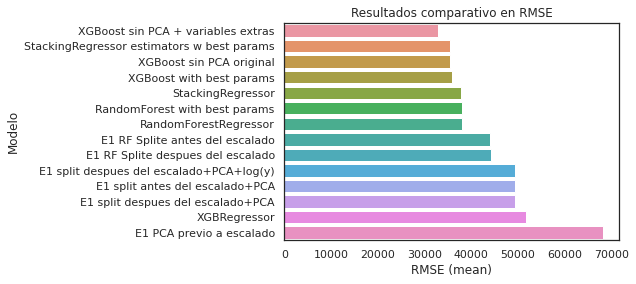

In [ ]:
# tmp=benchscores.iloc[6:,:4].sort_values(by=['RMSE (mean)'])
tmp=benchscores
chart = sns.barplot(x='RMSE (mean)',y='Modelo',data=tmp.sort_values(by=['RMSE (mean)']))
chart.set_title('Resultados comparativo en RMSE')
plt.show()

La comparación entre modelos la haremos utilizando RMSE, podemos concluir.
* El resultado se redujo de ~150000 con los modelos básicos a ~34000 con los modelos avanzados. entre 4 y 5 veces mejor.
* PCA  al 95% de información, influyó negativamente, quedó pendiente ensayar con distintos valores, Incluso empeoró el tiempo de entrenamiento.
* Las variables generadas, com un método "rústico" lograron mejorar, por unas milésimas el resultado.
* StackingRegressor: lo bueno de este modelo fue que sin ningún análisis, solo ejecutandolo, logramos mejorar el desempeño, a costa de mucho tiempo de entrenamiento.
* RandomForest también  quedó en el podio cuando lo evaluamos mirando solo el error, pero del lado de la performance en tiempo XGBoost fue infinitamente superior.
Los modelos de la "Parte A" fueron también muy rápidos de evaluar, quizá utilizando GridSearch sin fijar random_state podríamos habernos topado con algún desempeño mejor al obtenido.

Sin duda el mejor modelo fue XGboost sin PCA, tanto medido por el error como por el tiempo de entrenamiento.
A tener en cuenta que la velocidad de XGBoost se debió a que utilizamos el soporte de GPU, y podemos encontrarnos en ambientes donde no contemos con uno. XGBoost cuenta con una gama de booster pero nosotros nos limitamos a utilizar solo uno. 



##PARTE C - Interpretación de modelos

De acuerdo a lo que el modelo permite, responde algunas o todas las siguientes preguntas:

####9.
¿Qué variables fueron relevantes para el modelo para hacer una predicción? ¿Cuáles no? Si usaste una regresión lineal con regularización, presta atención a los parámetros (pendientes) obtenidas. Si usaste un modelo de ensamble en árboles, además de ver la importancia de cada atributo, también elige algunos árboles al azar y observa qué atributos considera importantes. ¿En qué se diferencian esos árboles? ¿Por qué? Finalmente, responde, ¿coincide con lo que esperabas a partir de tu experiencia con este dataset?



#### ¿Qué variables fueron relevantes para el modelo para hacer una predicción?

Debido a que se transformó el dataset mediante PSA, no es posible tracear las variables importantes del dataset original, si podemos investigar y ver qué features de la matriz resultante post PSA que fueron los importantes para el modelo,

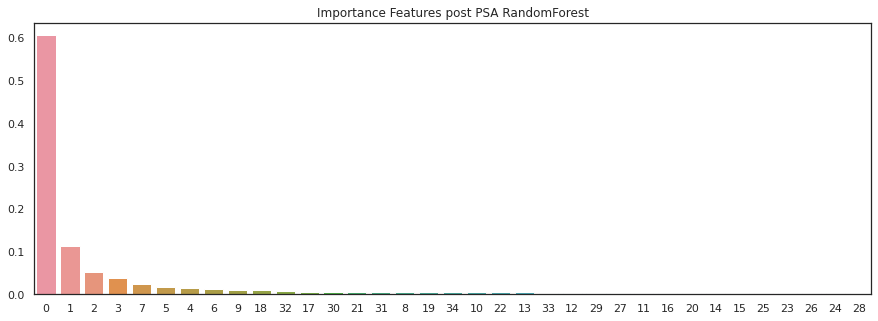

In [ ]:
sorted_idx=(-rs_rf.best_estimator_.feature_importances_).argsort()
y_ticks = np.arange(0,len(rs_rf.best_estimator_.feature_importances_))
plt.figure(figsize=(15,5))
chart=sns.barplot(y=rs_rf.best_estimator_.feature_importances_,
                  x=y_ticks, order=sorted_idx)
chart.set_yticklabels=sorted_idx
chart.set_title('Importance Features post PSA RandomForest')
plt.show()


Aquí podemos ver el MDI que es la media de cuánto disminuye la impureza de cada variable. Vamos a explorar algunos árboles.

Seleccionamos 5 aroboles del bosque para ver que tan similares o diferentes son.

In [ ]:
# rs_rf.best_estimator_.estimators_=RandomForestRegressor(n_estimators=20,max_features=0.1,warm_start=True).fit(X_train,y_train)

In [ ]:
np.random.seed(42)
random_idx=np.random.choice(np.arange(0, len(rs_rf.best_estimator_.estimators_)), replace=False, size=5)
len(rs_rf.best_estimator_.estimators_)
t=rs_rf.best_estimator_
# print(rs_rf.best_estimator_.n_features_)

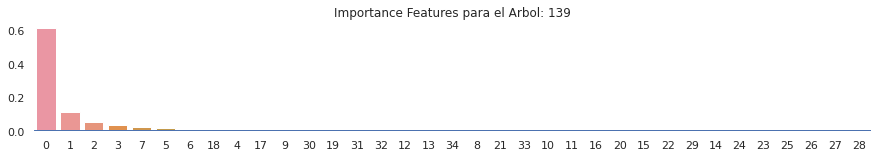

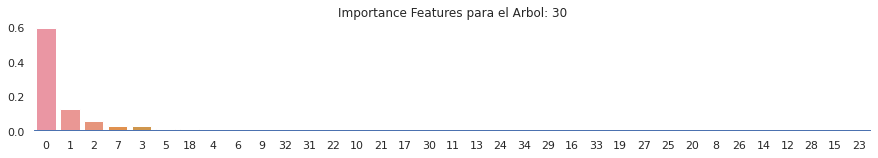

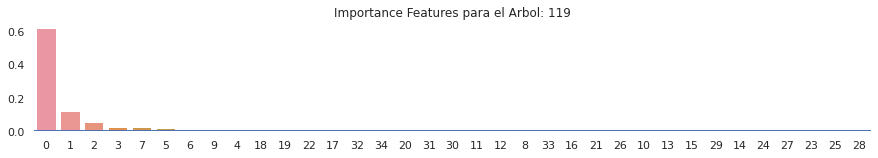

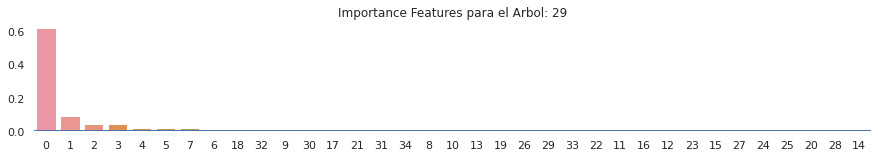

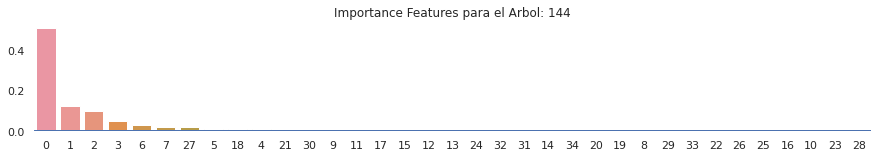

In [ ]:

subtrees_table=pd.DataFrame()
subtrees_fi=pd.DataFrame()
for idx in random_idx:
    sorted_idx=(-t[idx].feature_importances_).argsort()
    pd_=pd.DataFrame(
        {
            'Arbol':[idx],
            'max_deph':t[idx].max_depth,
            'deph':t[idx].get_depth(),
            'random_state': t[idx].random_state,
            'Decreace Impurity max': t[idx].feature_importances_.max(),
            # 'important feature value mean': t[idx].feature_importances_.mean(),
            'Decreace Impurity min': t[idx].feature_importances_.min(),
            'Leaves': t[idx].get_n_leaves(),
        }
    )
    
    pd1_=pd.DataFrame(
        {
            'Arbol': np.array([idx for _ in range(len(sorted_idx))]),
            'index':sorted_idx,
            'ImpurityDec':t[idx].feature_importances_[sorted_idx],
        }
    )
    subtrees_fi=subtrees_fi.append(pd1_)
    subtrees_table=subtrees_table.append(pd_)
    y_ticks = np.arange(0,len(t[idx].feature_importances_))
    plt.figure(figsize=(15,2))
    chart=sns.barplot(y=t[idx].feature_importances_,
                      x=y_ticks, order=sorted_idx)
    chart.set_yticklabels=sorted_idx
    chart.set_title('Importance Features para el Arbol: '+str(idx))
    sns.despine(bottom=True, left=True)
    sns.set(style='white', rc={"axes.facecolor": (0, 0, 0, 0)})
    plt.axhline(lw=3)
    plt.show()
subtrees_table=subtrees_table.reset_index()


#### ¿En qué se diferencian esos árboles? ¿Por qué?

Algunas diferencias que encontramos entre los árboles son

* radom_state: si bien fijamos el valor de random state para el forest, cada árbol tiene internamente su aleatoriedad. Que estos valores sean distintos entre árbol hace que los mismos se armen de formas distintas. La clave aquí es que parámetro max_features es menor que n_features, y el mejor feature para dividir al nodo es seleccionado un subconjunto de features de tamaño max_features, la aleatoriedad de este subconjunto está dictada por random_state.

* El orden de importancia de los features: se aprecia que en todos los subárboles el feature mas importante es 0, pero en el valor de reducción de impureza es de la variable 0 es distinta entre árboles.

* Cantidad de hojas: dado que el feature divide al nodo cambia, los árboles crecen de forma diferente y alcanzan su máxima profundidad, ya sea la definida o por que el criterio de finalización se cumple. Todos estos árboles tienen una profundidad de 20, podemos estar casi seguros que fue por el parámetro max_deph.

In [ ]:
subtrees_table

index  Arbol  max_deph  ...  Decreace Impurity max  Decreace Impurity min  Leaves
0      0    139        20  ...               0.617226               0.002035   18843
1      0     30        20  ...               0.597104               0.002756   19260
2      0    119        20  ...               0.619922               0.002759   18586
3      0     29        20  ...               0.622875               0.002419   18955
4      0    144        20  ...               0.511202               0.002592   18891

[5 rows x 8 columns]

Podemos observar que max_deph y deph son iguales, esto significa que los arboles crecieron hasta el limite maximo indicado por el hiperametro max_deph y no por los  hiparpametros 'min_samples_leaf' y 'min_samples_split', que tambien deciden cuando un nodo puede hacer split o no y por ende determinan que tanto va a crecer el arbol.

#### ¿coincide con lo que esperabas a partir de tu experiencia con este dataset?

Sinceramente, esperaba poder llegar un poco más lejos, conseguir un error más bajo. Me puse el desafío de generar alguna variable ganadora con dbscan y kmens pero ninguna prueba me llevó a buen puerto.
Me resistí a la tentación de calcular el precio del m2 por barrio o por cuadrícula, para no generar una tendencia que pudiera viciar el resultado.
La generación de variables, en mi caso fue extraer características de las propiedades de las columnas título y descripción, parecen aportar algo de valor, por lo menos se puede ver en [esta celda](https://colab.research.google.com/drive/1ywCAtYstyhKd_4UY2keFy5QZulozTEUw#scrollTo=nxoMkDj8l6v_&line=2&uniqifier=1) cuando lo probamos con un treeregressor sin PCA, pero no podemos estar seguro que se conservarán después de aplicado PCA.
Fui muy conservador con las filas duplicadas, no las habia descubierto en el proyecto anterior y decidí no eliminarlas porque me costaba diferenciar si eran datos inválidos o datos genuinos.

###10.
¿Cómo es la distribución de errores (regresión) o qué clases se confunden entre sí (clasificación)? ¿Dónde falla? ¿A qué se debe?

Vamos a tratar como es el termino error, Vamos a verlo primero en general.

In [ ]:
# benchscores=pd.DataFrame()
data1.price=np.log1p(data1.price)
data1.surface_covered=np.log1p(data1.surface_covered)
data1.surface_total=np.log1p(data1.surface_total)
X_train, X_test, y_train, y_test =escal_split_after(data1)
# X_train, X_test, y_train, y_test =escal_split_after(data1.drop([*perks],axis=1))
data1.price=np.exp(data1.price) - 1 
data1.surface_covered=np.exp(data1.surface_covered) - 1
data1.surface_total=np.exp(data1.surface_total) - 1
pca = PCA(.95)
pca.fit(X_train)
X_train = pca.transform(X_train)
X_test = pca.transform(X_test)
X=np.r_[X_train,X_test]
y=np.r_[y_train,y_test]

In [ ]:
y_pred = rs_rf.best_estimator_.predict(X_test)
y_pred=pd.DataFrame(y_pred,index=y_test.index)

y_pred_err=l3[l3.index.isin(y_pred.index)].join(
    property_type[property_type.index.isin(y_pred.index)]
    ).join(
    np.exp(y_pred)-1
    ).join(
    pd.DataFrame({'price_log1p':y_pred[0]})
    ).join(
    pd.DataFrame({'type': np.array(['pred' for _ in range(len(y_pred))])},index=y_pred.index)
    )
y_pred_err.rename(columns={0:'price'},inplace=True)
y_test_err=l3[l3.index.isin(y_test.index)].join(
    property_type[property_type.index.isin(y_test.index)]
    ).join(
    np.exp(y_test)-1
    ).join(
    pd.DataFrame({'price_log1p':y_test})
    ).join(
    pd.DataFrame({'type': np.array(['test' for _ in range(len(y_test))])},index=y_test.index)
    )
y_err=y_test_err.append(y_pred_err)
y_err[['bins']]=pd.cut(y_pred_err['price'], bins=np.linspace(0, 900000, 10))

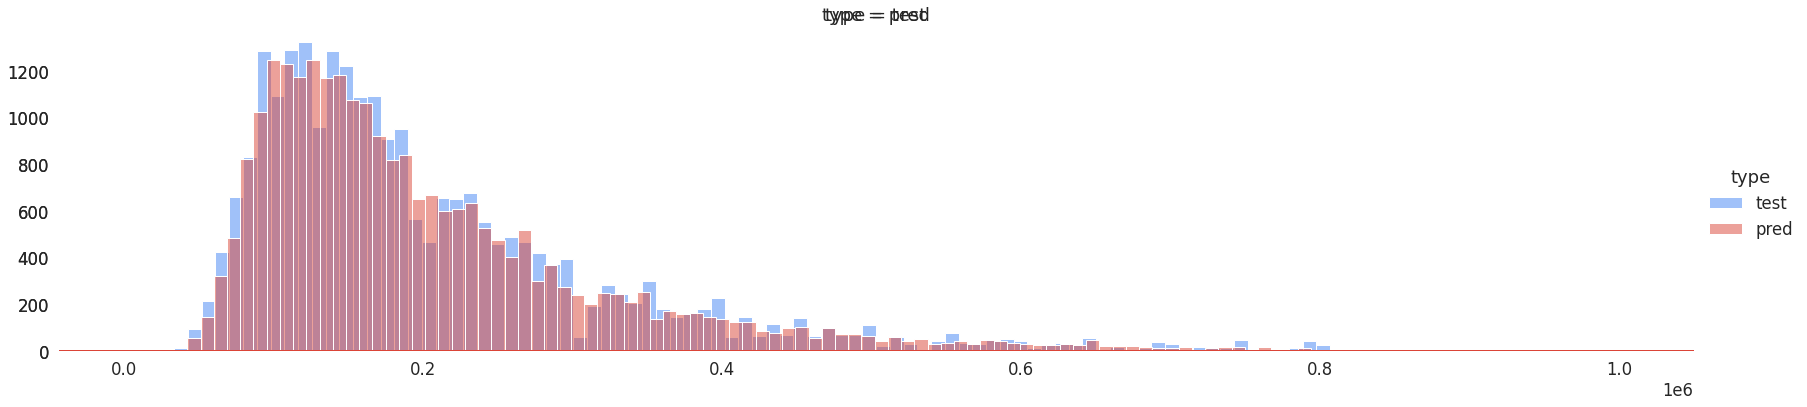

In [ ]:
sns.set(style='white', rc={"axes.facecolor": (0, 0, 0, 0)},font_scale=1.5)

g = sns.FacetGrid(y_err, aspect=8, row='type', hue='type', height=3,
                  palette=['#4285F4', '#DB4437', '#0F9D58'])
g = g.map(sns.histplot, 'price', alpha=0.5)

g = g.map(plt.axhline, lw=3)
# g.map(label, column)
# g.set_titles('')
g.fig.subplots_adjust(hspace=-1)
# g.set(yticks=[])
g.despine(bottom=True, left=True)
g.add_legend()
sns.set()

En este historigrama se puede ver que los valores reales versus los predichos mantienen una ditribucion similar, pero los bin estan descalzados y no son iguales, vamos a tratar de descomponerlo para ver donde o con que se comporta pero o mejor la predicción

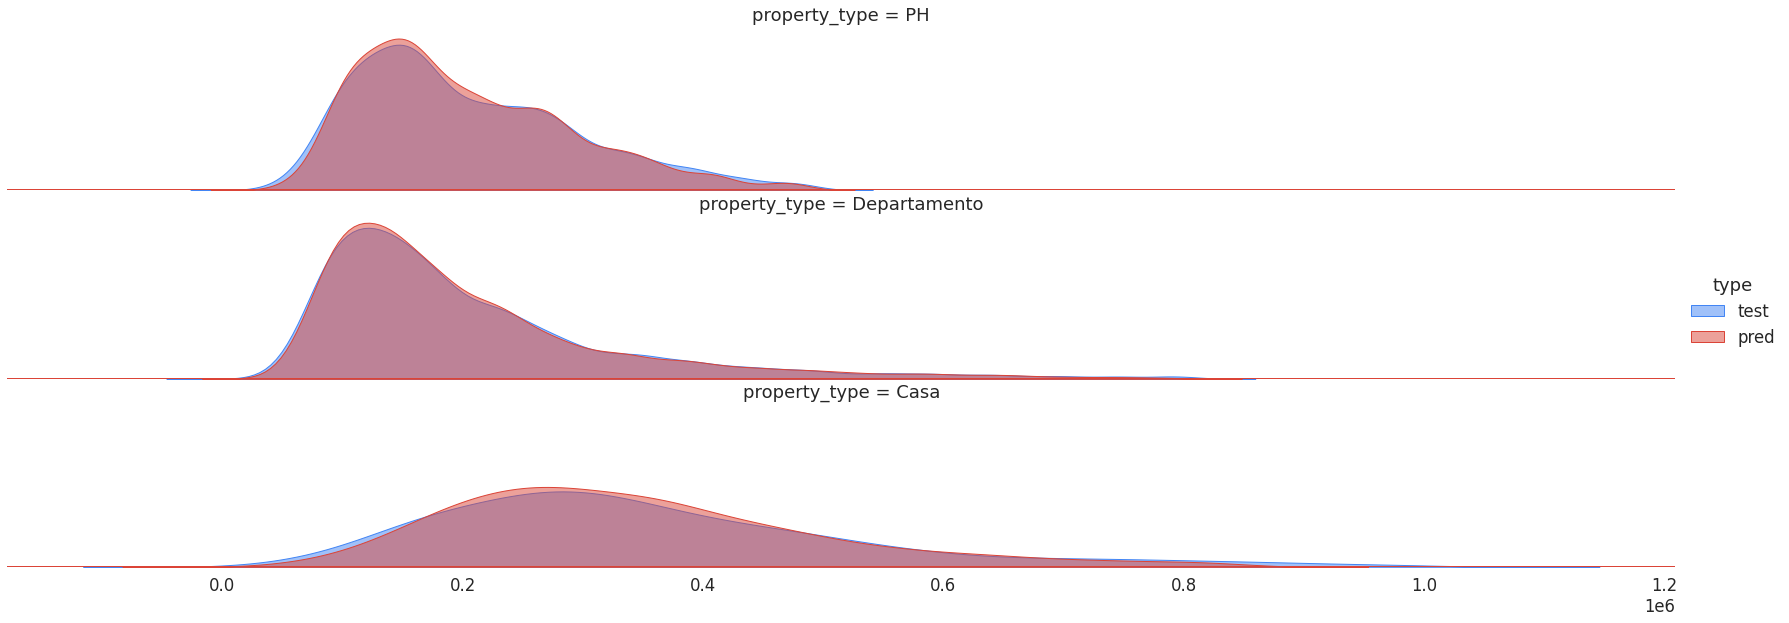

In [ ]:
sns.set(style='white', rc={"axes.facecolor": (0, 0, 0, 0)}, font_scale=1.5)

g = sns.FacetGrid(y_err, aspect=8, row='property_type', hue='type', height=3,
                  palette=['#4285F4', '#DB4437', '#0F9D58'])
g = g.map(sns.kdeplot, 'price', alpha=0.5, shade=True)

g = g.map(plt.axhline, lw=3)
# g.map(label, column)
# g.set_titles('')
g.fig.subplots_adjust(hspace=.15)
g.set(yticks=[])
g.despine(bottom=True, left=True)
g.add_legend()
sns.set()

Aquí puedes ver que la predicción se comporta de forma bastante similar por cada tipo de propiedad, a pesar que la distribución es distinta entre tipos de propiedad, la predicción acompaña, con la misma distribución, incluso los descalces están en los mismos rangos de precio.

Podríamos pensar que el modelo está interpretando de forma consistente la relación entre el tipo de propiedad y el precio, y también puede ser que no exista relación, como se veía en el mapa de correlación donde la que más correlación tiene con la variable target era "Departamento" de forma negativa y cercana a 0.

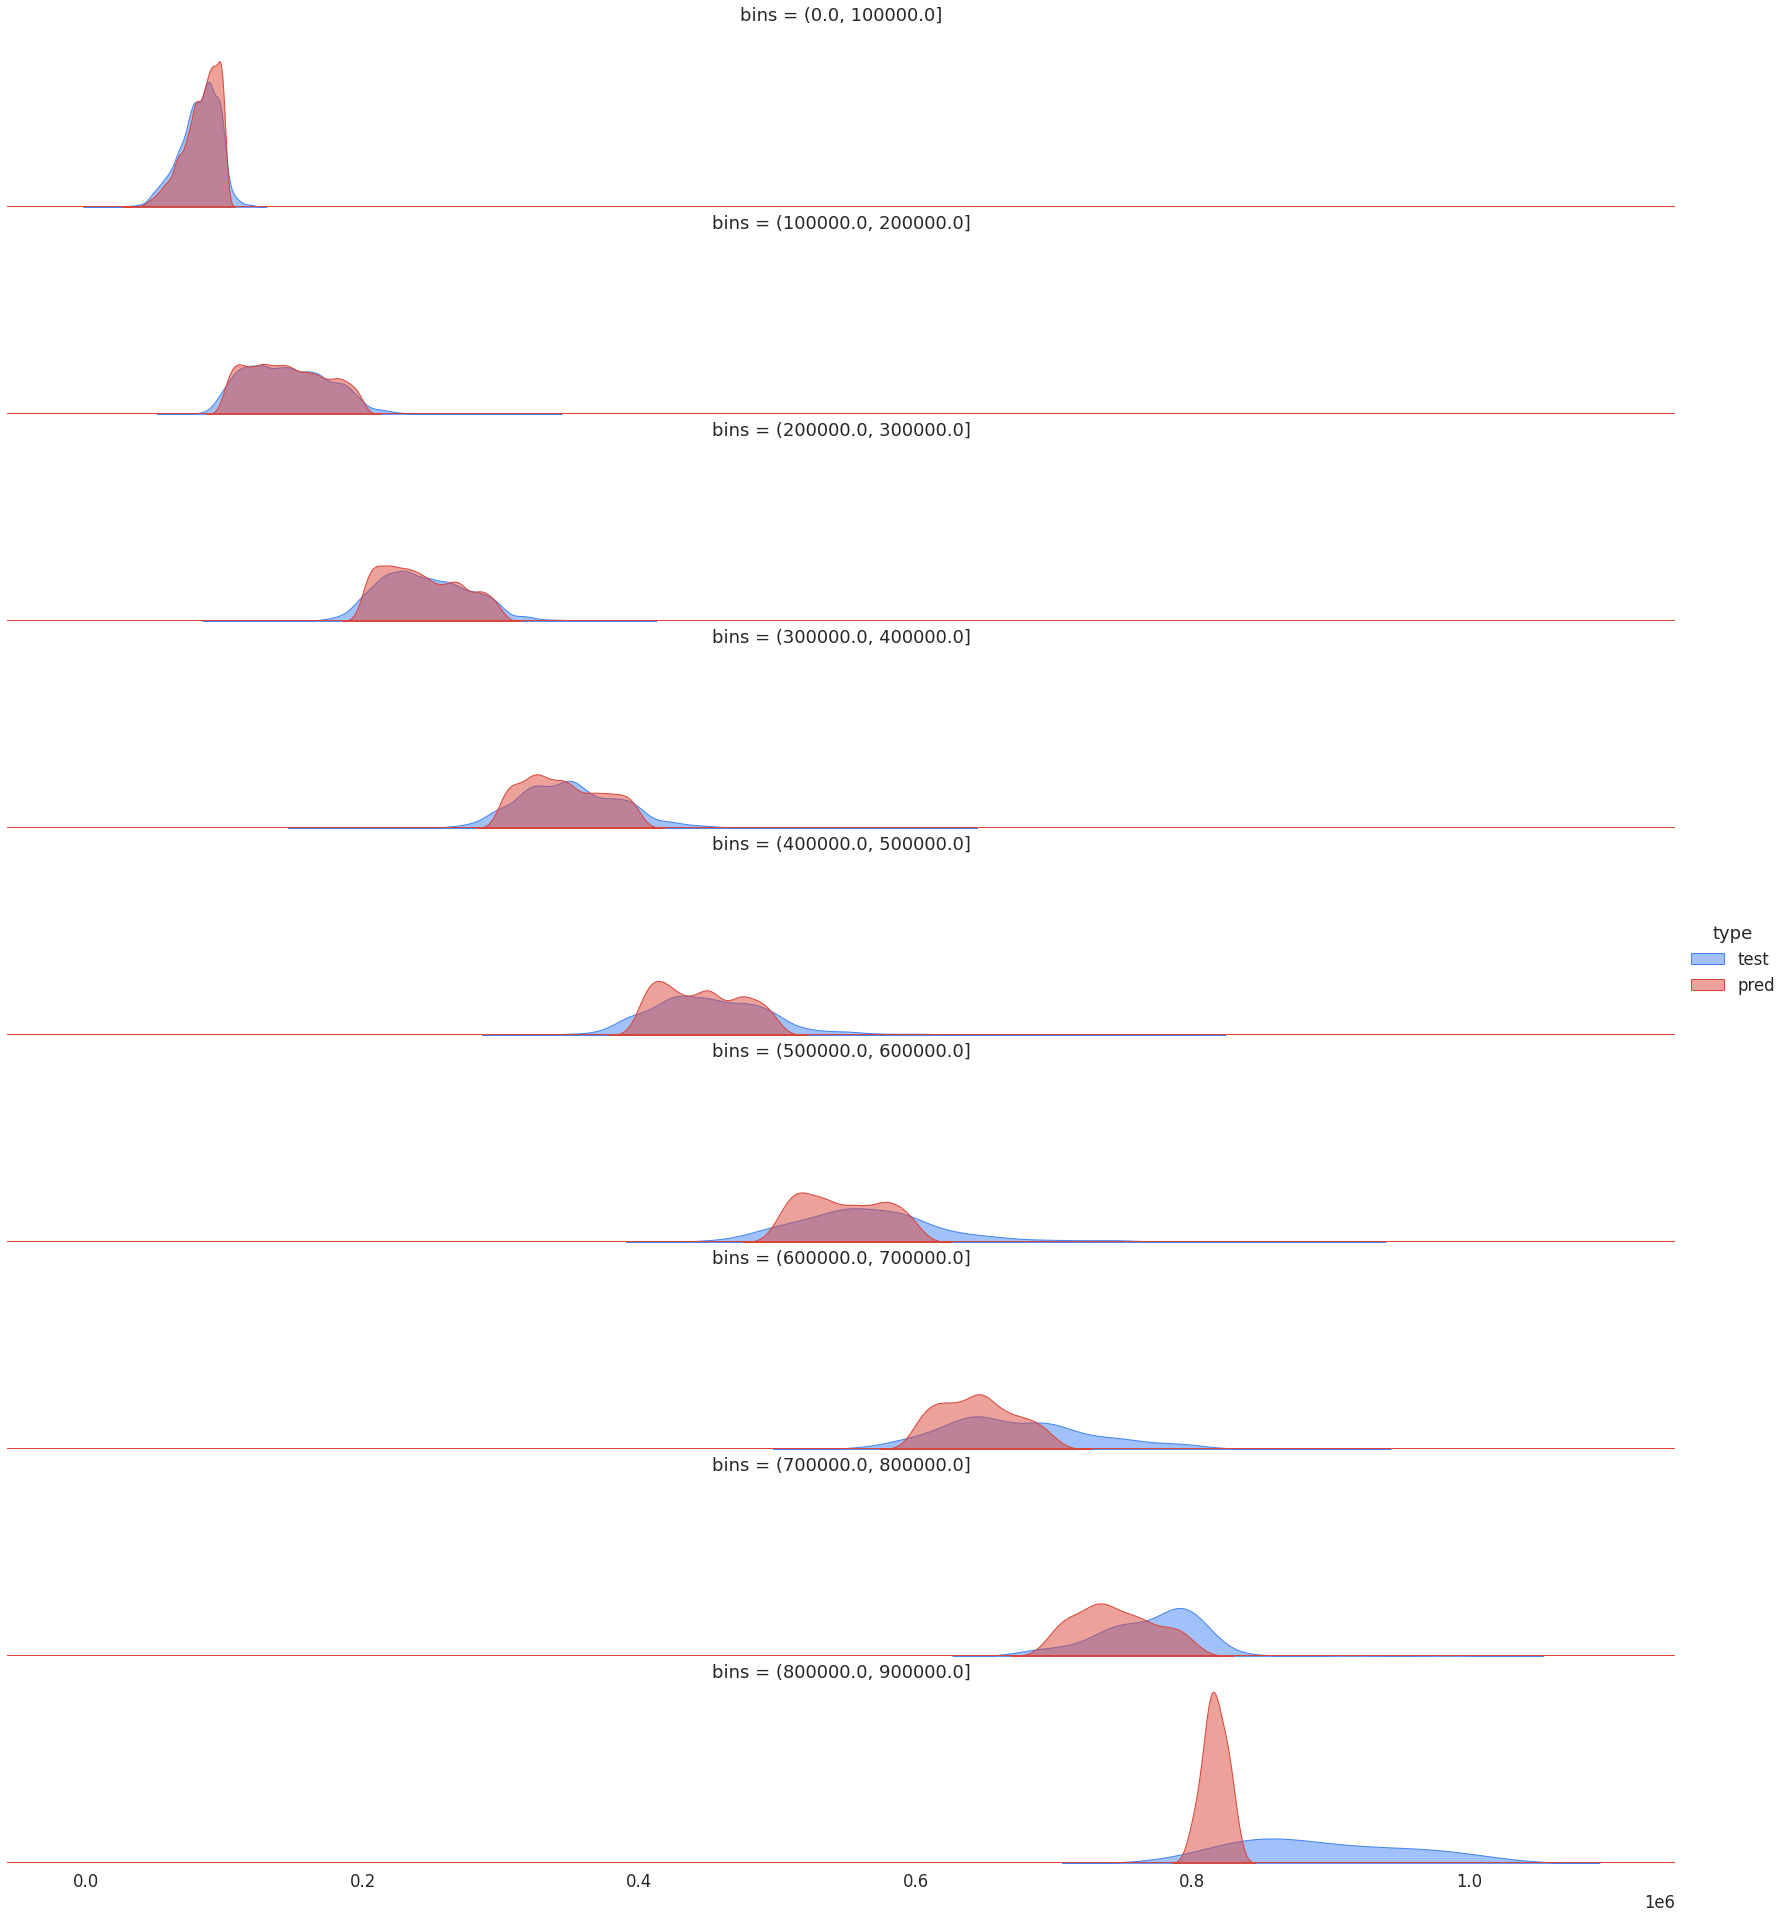

In [ ]:
sns.set(style='white', rc={"axes.facecolor": (0, 0, 0, 0)}, font_scale=1.5)

g = sns.FacetGrid(y_err, aspect=8, row='bins', hue='type', height=3,
                  palette=['#4285F4', '#DB4437', '#0F9D58'])
g = g.map(sns.kdeplot, 'price', alpha=0.5, shade=True)

g = g.map(plt.axhline, lw=3)
# g.map(label, column)
# g.set_titles('')
g.fig.subplots_adjust(hspace=.15)
g.set(yticks=[])
g.despine(bottom=True, left=True)
g.add_legend()
sns.set()

Podemos ver que ahora, la predicción no acompaña tanto cuando dividimos el dataset por rangos de precio, y que a medida que el precio aumenta la predicción es menos precisa. 
Vamos a ver si podemos desgranar un poco más.

Text(0.5, 1.0, 'Valore real sobre predicción en USD')

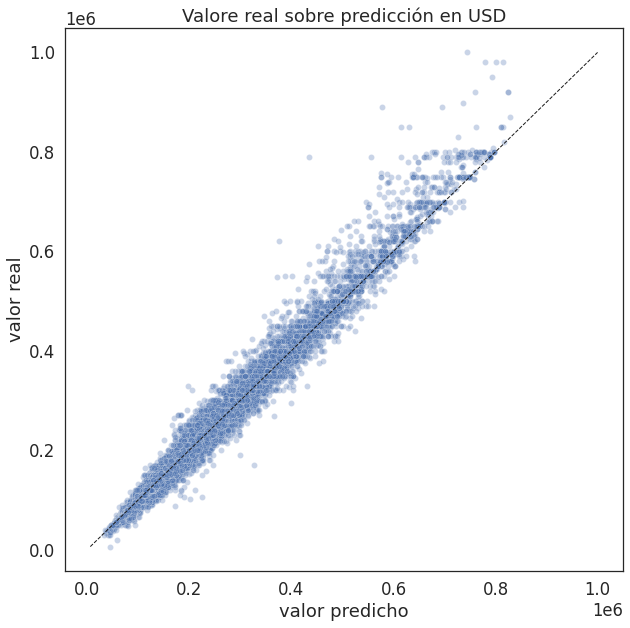

In [ ]:
tmp=pd.DataFrame({
    'valor real':y_err[y_err.type=='test'].price.astype(int),
    'valor predicho':y_err[y_err.type=='pred'].price.astype(int),
    'bins': y_err[y_err.type=='test'].bins
    }
)
tmp
plt.figure(figsize=(10,10))
sns.set(style='white', rc={"axes.facecolor": (0, 0, 0, 0)}, font_scale=1.5)
chart=sns.scatterplot(y='valor real',x='valor predicho',data=tmp, alpha=.3)
chart.plot([tmp['valor real'].min(), tmp['valor real'].max()], [tmp['valor real'].min(),tmp['valor real'].max()], 'k--', lw=1)
chart.set_title('Valore real sobre predicción en USD')
# chart.legend()
# chart.legend(loc='right', bbox_to_anchor=(1.25, 0.5), ncol=1)

Por si hace falta aclararlo, la linea punteada en negro son los valores realaes, divide el cuadrilatero en dos, los puntos por arriba de esta diagonal son predicciones subvaluadas, y los que estan por debajo son sobre valuadas.
Podemos ver que la densidad de puntos para todo el rango de precios el modelo tiende más a subvaluar que a sobrevaluar.

La nube se ensancha a medida que el precio aumenta y podríamos mal interpretar, pensado que se desempeñan peor a medida que aumenta el valor real va aumentando, pero esto no es necesariamente así.
Tratamos de desmenuzar.


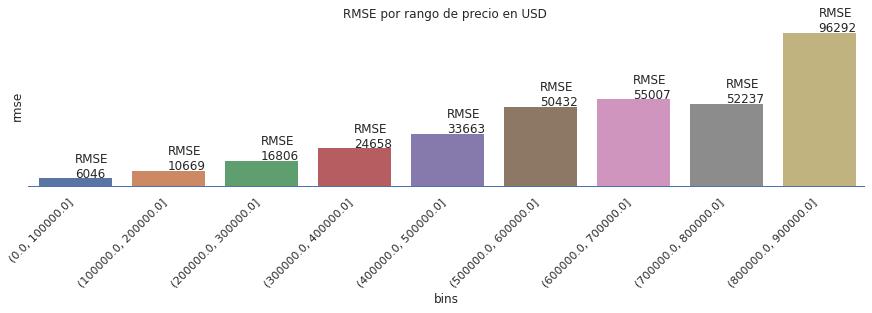

In [ ]:
subs=pd.DataFrame()
sub={}
for bins in y_err.sort_values(by=['bins'],axis=0)['bins'].unique():
  rmse=mean_squared_error(
      y_err[(y_err['bins']==bins) & (y_err['type']=='test')].price,
      y_err[(y_err['bins']==bins) & (y_err['type']=='pred')].price,
      squared=False
  )
  # print(bins,rmse)
  r2=r2_score(
      y_err[(y_err['bins']==bins) & (y_err['type']=='test')].price_log1p,
      y_err[(y_err['bins']==bins) & (y_err['type']=='pred')].price_log1p,
  )
  # print(bins,r2)
  # print(y_err[(y_err['bins']==bins) & (y_err['type']=='pred')].price.count())
  total_samples=y_err[(y_err['bins']==bins) & (y_err['type']=='pred')].price_log1p.count()
  meanprice=y_err[(y_err['bins']==bins) & (y_err['type']=='test')].price.mean()
  error_percent=(rmse/meanprice)*100
  subs=subs.append({
      "bins":bins,
       "r2":r2,
       'rmse':rmse,
       'total_samples':total_samples,
       'meanprice':meanprice,
       'error_percent':error_percent
       },ignore_index=True)
# r2_score(y_err[(y_err['type']=='true')].price,y_err[(y_err['type']=='pred')].price)
r2_score(y_test,y_pred)
sns.set(style='white', rc={"axes.facecolor": (0, 0, 0, 0)})
plt.figure(figsize=(15,3))
chart=sns.barplot(x='bins',y='rmse',data=subs)

for index, row in subs.iterrows():
  chart.text(row.name,row.rmse, 'RMSE\n'+str(int(row.rmse)))
chart.set(yticks=[])
chart.text
chart.set_xticklabels(chart.get_xticklabels(), rotation=45, horizontalalignment='right')
# chart=sns.barplot(subs.bins,-subs.total_samples*10,data=subs)
chart.set_title('RMSE por rango de precio en USD ')
chart.set_label('despues')
sns.despine(bottom=True, left=True)
plt.axhline(lw=3)
g.add_legend()
plt.axhline(lw=3)

plt.show()


De nuevo, aca se muestra el error por segmento de precios. Si bien el error bruto es peor, si lo comparamos con el rango de precios, es proporcionalmente similar.

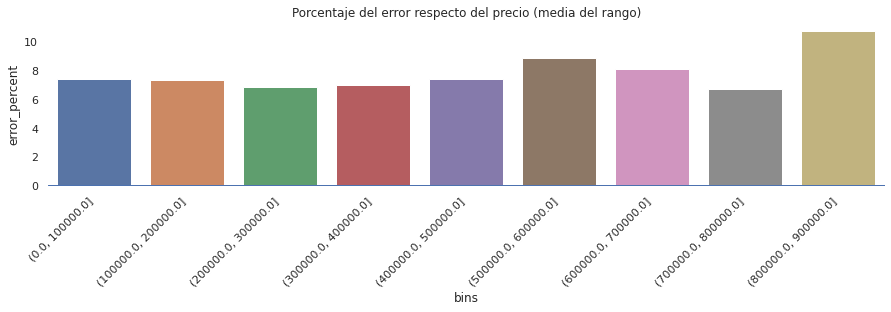

In [ ]:
plt.figure(figsize=(15,3))
chart=sns.barplot(x='bins',y='error_percent',data=subs)
chart.set_xticklabels(chart.get_xticklabels(), rotation=45, horizontalalignment='right')
chart.set_title('Porcentaje del error respecto del precio (media del rango)')
sns.despine(bottom=True, left=True)
plt.axhline(lw=3)
plt.show()

Aca podemos ver que el porcentaje que representa el error respecto la media de rango de precio va del 6 al 12 % aproximadamente. Y si bien es un rango amplio no es brutalmente dispar.

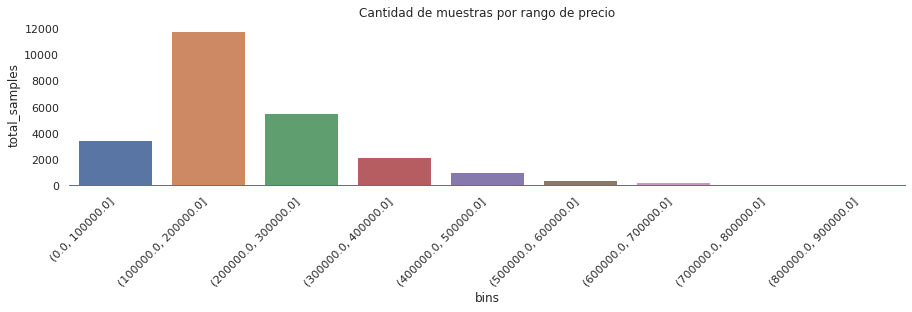

In [ ]:
plt.figure(figsize=(15,3))
chart=sns.barplot(x='bins',y='total_samples',data=subs)
chart.set_xticklabels(chart.get_xticklabels(), rotation=45, horizontalalignment='right')
chart.set_title('Cantidad de muestras por rango de precio')
sns.despine(bottom=True, left=True)
plt.axhline(lw=3)
plt.show()

De este último gráfico quizá podemos  deducir que el peor desempeño en el rango superior de precio se debe a la poca cantidad de muestras, es difcil para el modelo en esos "cisnes negros" determinar el precio.

## Cierre

Imputación de los valores faltantes: Este punto fue el que más dudas me genera, sobre todo para aquellas instancias donde los valores de superficie total y cubierta estaban ausentes.

Instancias Duplicadas: Había muchas instancias duplicadas y tomamos más o menos arbitrariamente la decisión de conservarlas, no recorrimos el camino de entrenar los modelos con o sin estas instancias.

Overfitting:  Tratamos todo el tiempo de ir a fondo con la mejora de la predicción sin evaluar si en el camino dejamos el modelo dejó de generalizar lo suficiente.

No evaluamos el modelo con el dataset completo solo lo hicimos con CABA.

Me faltó explorar más a fondo clustering, no logré llegar al lugar donde pretendía, que era generar una variable que aporta valor, ni logre en las pruebas visualizar nada.